In [6]:
import numpy as np
import scipy
from scipy.ndimage import gaussian_filter1d
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
%matplotlib inline
import seaborn as sns

import sys,os,pdb,copy,pickle
from importlib import reload
import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp
import database
db = database.db

import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf
import pingouin as pg

In [ ]:
figdir = '/mnt/home/szheng/ceph/place_variability/fig/cosyne'

In [7]:
data_dir_full=db.query('owner=="roman"')['data_dir_full'][0]
data_dir_full
db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False).head(10)

data_dir_full  \
animal_name                                                        
e13_26m1    0  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_26...   
e15_13f1    0  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
            1  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
            2  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
            3  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
e13_26m1    1  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_26...   
e13_16f1    7  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_16...   
e13_26m1    2  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_26...   
e16_3m2     3  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m...   
e16_3m1     0  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m...   

                     sess_name animal_name.1        date  \
animal_name                                                
e13_26m1    0  e13_26m1_210913      e13_26m1  2021-09-13   
e15_13f1    0  e15_13f1_220117      e15_13f1  2022-01-17   
            1  e15_13f1_220118      e15_13f1  2022-01-18   
            2  e15_13f1_220119      e15_13f1  2022-01-19   
            3  e15_13f1_220120      e15_13f1  2022-01-20   
e13_26m1    1  e13_26m1_211019      e13_26m1  2021-10-19   
e13_16f1    7  e13_16f1_210328      e13_16f1  2021-03-28   
e13_26m1    2  e13_26m1_211116      e13_26m1  2021-11-16   
e16_3m2     3   e16_3m2_211213       e16_3m2  2021-12-13   
e16_3m1     0   e16_3m1_210111       e16_3m1  2021-01-11   

                                    behavior  performance  ntrials  \
animal_name                                                          
e13_26m1    0                    alternation     0.956522       69   
e15_13f1    0                    alternation     0.617647       34   
            1   ['alternation' 'linearMaze']     0.740741       27   
            2  ['alternation' 'alternation']     0.721311       61   
            3   ['alternation' 'linearMaze']     0.800000       45   
e13_26m1    1  ['alternation' 'alternation']     0.730769       78   
e13_16f1    7                    alternation     0.850000       20   
e13_26m1    2   ['alternation' 'linearMaze']     0.850000       20   
e16_3m2     3  ['alternation' 'alternation']     0.703704       54   
e16_3m1     0                    alternation     0.882353       17   

               ngoodtrials  n_neurons  n_pyr_putative  owner   data_root  
animal_name                                                               
e13_26m1    0           69        482             422  roman  roman_data  
e15_13f1    0           34        376             333  roman  roman_data  
            1           27        363             318  roman  roman_data  
            2           61        343             288  roman  roman_data  
            3           45        303             248  roman  roman_data  
e13_26m1    1           78        271             228  roman  roman_data  
e13_16f1    7           20        211             174  roman  roman_data  
e13_26m1    2           20        209             173  roman  roman_data  
e16_3m2     3           54        207             163  roman  roman_data  
e16_3m1     0           17        203             162  roman  roman_data

In [105]:
# data_dir_full = '/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/'
# data_dir_full = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][0]
data_dir_full = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][0]

In [103]:
# data_dir_full=db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False).iloc[61]

In [295]:
mat_to_return=prep.load_stuff(data_dir_full)

smth_in_bin=2.5 
speed_thresh=1.
nbins=100
speed_key='v'

prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load={})
spk_beh_df=prep_res['spk_beh_df']
_,spk_beh_df=dpp.group_into_trialtype(spk_beh_df)
cell_cols_d = prep_res['cell_cols_d']
# beh_df = prep_res['beh_df'].as_dataframe()
beh_df = prep_res['beh_df']
beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)
spike_trains = prep_res['spike_trains']
cell_cols = cell_cols_d['pyr']
spk_beh_df,lin_bins = dpp.add_lin_binned(spk_beh_df,nbins=nbins)
# fr maps

fr_map_dict=pa.get_fr_map_trial(spk_beh_df,cell_cols,trialtype_key='trial_type',speed_thresh=speed_thresh,order=['smooth','divide'],speed_key=speed_key)
fr_map_trial_d = {k:val[0] for k,val in fr_map_dict.items()}
fr_map_d,count_d,occu_d = pf.ratemap_from_spk_beh_df_alltrialtype(spk_beh_df,cell_cols,speed_thresh=speed_thresh,nbins=nbins,smth_in_bin=smth_in_bin,speed_key=speed_key)



In [120]:
fr_map_null=misc.get_res(os.path.join(data_dir_full,'py_data'),'fr_map_null_trialtype_vthresh.p',False)[1]

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/fr_map_null_trialtype_vthresh.p exists; loading---


In [126]:
reload(pf)
pf.field_detection_from_avg(fr_map_d,fr_map_trial_d,fr_map_null)

({(0,
   0.0):                       0          1          2          3          4   \
  fr_mean 3   0   0.574760   1.987384   0.899406   0.000000   0.429717   
          27  0  14.467861  14.263197  23.110141  20.218518  23.995653   
          29  0   5.250648   7.947645  12.210515   9.894212   5.199501   
              1  10.561324   8.811466  17.615051  16.964147   6.628209   
              2   3.509398  17.413386  13.647586   7.322407   9.204354   
  ...                  ...        ...        ...        ...        ...   
  std     465 0   0.596658   2.923143        NaN   2.424171        NaN   
          475 0   3.522671   3.147896   3.160302   3.041523   2.802866   
          476 0   2.180316   2.551350   2.477388   2.864476   2.457845   
              1   0.666322   0.508244   0.686098   0.748582   0.772699   
          480 0   3.300609   3.007897   3.647449   5.154504   3.475804   
  
                        5          6          7          8          9   ...  \
  fr_mean 3   0  

In [209]:
place_field_res=pf.field_detection_both_avg_trial_wrapper(data_dir_full, dosave=True,force_reload=False,nbins = 100, 
                                        save_fn = 'place_field_avg_and_trial_vthresh.p', 
                                        shuffle_fn='fr_map_null_trialtype_vthresh.p',
                                        smth_in_bin=2.5, speed_thresh=1.
                                        )

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/fr_map_null_trialtype_vthresh.p exists; loading---
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


In [208]:
# place_field_res=pf.field_detection_both_avg_trial_wrapper(data_dir_full, dosave=True,force_reload=False,nbins = 100, 
#                                         save_fn = 'place_field_avg_and_trial.p', 
#                                         shuffle_fn='fr_map_null_trialtype.p',
#                                         smth_in_bin=2.5, speed_thresh=1.
#                                         )

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/fr_map_null_trialtype.p exists; loading---
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/place_field_avg_and_trial.p exists; loading---


In [93]:
def main(data_dir_full):
    place_field_res=pf.field_detection_both_avg_trial_wrapper(data_dir_full, dosave=True,force_reload=False,nbins = 100, 
                                        save_fn = 'place_field_avg_and_trial.p', 
                                        shuffle_fn='fr_map_null_trialtype.p',
                                        smth_in_bin=2.5, speed_thresh=1.
                                        )
    
    X_all = {}
    X_all_norm = {}
    com_agg_all = {}
    fr_key = 'fr_mean'
    trial_type_l = [(0,0),(0,1)]

    detection_type_l =[d for d in place_field_res.keys() if 'kwargs' not in d]

    X_all_detection = {k:{} for k in detection_type_l}
    X_all_norm_detection = {k:{} for k in detection_type_l}
    com_agg_all_detection = {k:{} for k in detection_type_l}

    for detection in detection_type_l:
        X_all = {}
        X_all_norm = {}
        com_agg_all = {}
        for tt in trial_type_l:
            X = place_field_res[detection]['params'][tt].loc[fr_key]
            com_agg = place_field_res[detection]['all_fields'][tt].loc[:,'com']
            X_all_detection[detection][tt] = X
            X_norm = X/X.max(axis=1).values[:,None]
            X_all_norm_detection[detection][tt] = X_norm
            com_agg_all_detection[detection][tt] = com_agg
    
    
    X_to_be_analyzed_detection = {}
    for k,val in X_all_norm_detection.items():
        X_to_be_analyzed=cpa.turn_X_into_pwc_sweep(val,pen_l=[0.3,0.5])
        X_to_be_analyzed_detection[k] = X_to_be_analyzed
    
    
    plt.ioff()
    # tosweep_key_l = ['switch_magnitude','high_thresh']
    # tosweep_val_l = [np.arange(0,0.7,0.1).round(1),np.arange(0.3,0.8,0.1).round(1)]
    # kwargs_l = [dict(low_thresh=1,high_thresh=0),
    #     dict(low_thresh=0.2,switch_magnitude = 0),
    # ]
    tosweep_key_l = ['switch_magnitude']
    tosweep_val_l = [np.arange(0,0.7,0.2).round(1)]
    kwargs_l = [dict(low_thresh=1,high_thresh=0)
    ]
    min_size = 1

    res_to_save_data_detection = {}
    for detection,X_to_be_analyzed in X_to_be_analyzed_detection.items():
        cdf_alltrialtype,sig_alltrialtype,sr_alltrialtype,changes_df_alltrialtype,fig_alltrialtype = cpa.sweep_test_switch_ratio_multisweep_alltrialtype_multipreprocess(X_to_be_analyzed,min_size,tosweep_key_l,tosweep_val_l,kwargs_l,detect_func=cpa.detect_switch_pwc,alpha=0.05,do_bonf=True,doplots=True,nrepeats=1000)    

        res_to_save_data = dict(
            X = X_to_be_analyzed,
            cdf=cdf_alltrialtype,
            sig=sig_alltrialtype,
            sr=sr_alltrialtype,
            changes_df=changes_df_alltrialtype,
            fig=fig_alltrialtype
        )

        res_to_save_data_detection[detection] = res_to_save_data
    
    res_to_save_dir = os.path.join(data_dir_full,'py_data','switch_analysis')
    if not os.path.exists(res_to_save_dir):
        os.makedirs(res_to_save_dir)
        print(f'{res_to_save_dir} made!',flush=True)

    res_to_save_name = f'shuffle_detection_switch_res_switch_magnitude_only_{fr_key}.p'
    res_to_save_fn  = os.path.join(res_to_save_dir,res_to_save_name+'.p')
    res_to_save_data = res_to_save_data_detection
    pickle.dump(res_to_save_data,open(res_to_save_fn,'wb'))
    print(f'{res_to_save_fn} saved!', flush=True)
    return res_to_save_data
    

In [ ]:
import tqdm
db_sorted=db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)
resres_l = []
failed_l = []
for ii in tqdm.tqdm(range(db_sorted.shape[0])):
    ddf = db_sorted.iloc[ii]['data_dir_full']
    try:
        resres=main(ddf)
        resres_l.append(resres)
    except:
        failed_l.append(ddf)
        print(f'{ii} failed')
        
        
        

  0%|          | 0/67 [00:00<?, ?it/s]

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/fr_map_null_trialtype.p exists; loading---
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/place_field_avg_and_trial.p exists; loading---
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and 

  1%|▏         | 1/67 [03:11<3:31:10, 191.98s/it]

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/fr_map_null_trialtype.p exists; loading---
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/place_field_avg_and_trial.p exists; loading---
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and 

/mnt/home/szheng/projects/nmf_analysis/change_point_plot.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,axs = plt.subplots(len(keys),2,figsize=(6*2,3*len(keys)),sharey=False)


/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/switch_analysis/shuffle_detection_switch_res_switch_magnitude_only_fr_mean.p.p saved!


  3%|▎         | 2/67 [05:33<2:55:33, 162.06s/it]

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/fr_map_null_trialtype.p exists; loading---
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/place_field_avg_and_trial.p exists; loading---
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory 

  4%|▍         | 3/67 [07:49<2:40:15, 150.25s/it]

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220119/py_data/fr_map_null_trialtype.p exists; loading---
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220119/py_data/place_field_avg_and_trial.p exists; loading---
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory 

  6%|▌         | 4/67 [10:06<2:32:30, 145.25s/it]

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220120/py_data/fr_map_null_trialtype.p exists; loading---
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220120/py_data/place_field_avg_and_trial.p exists; loading---
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory 

  7%|▋         | 5/67 [12:31<2:30:00, 145.17s/it]

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211019/py_data/fr_map_null_trialtype.p exists; loading---
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211019/py_data/place_field_avg_and_trial.p exists; loading---
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory 

  9%|▉         | 6/67 [14:57<2:27:39, 145.24s/it]

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210328/py_data/fr_map_null_trialtype.p exists; loading---
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210328/py_data/place_field_avg_and_trial.p exists; loading---
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and 

 10%|█         | 7/67 [16:58<2:17:23, 137.39s/it]

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211116/py_data/fr_map_null_trialtype.p exists; loading---
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211116/py_data/place_field_avg_and_trial.p exists; loading---
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory 

 12%|█▏        | 8/67 [19:01<2:10:31, 132.74s/it]

/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211213/py_data/fr_map_null_trialtype.p exists; loading---
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211213/py_data/place_field_avg_and_trial.p exists; loading---
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file

 13%|█▎        | 9/67 [21:05<2:05:43, 130.05s/it]

/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m1/e16_3m1_210111/py_data/fr_map_null_trialtype.p exists; loading---
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m1/e16_3m1_210111/py_data/place_field_avg_and_trial.p exists; loading---
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and work

 15%|█▍        | 10/67 [23:03<2:00:10, 126.51s/it]

/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211212/py_data/fr_map_null_trialtype.p exists; loading---
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211212/py_data/place_field_avg_and_trial.p exists; loading---
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file

 16%|█▋        | 11/67 [25:11<1:58:22, 126.82s/it]

/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211211/py_data/fr_map_null_trialtype.p exists; loading---
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211211/py_data/place_field_avg_and_trial.p exists; loading---
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file

 18%|█▊        | 12/67 [27:20<1:56:53, 127.52s/it]

/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m1/e16_3m1_210203/py_data/fr_map_null_trialtype.p exists; loading---
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m1/e16_3m1_210203/py_data/place_field_avg_and_trial.p exists; loading---
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and work

 21%|██        | 14/67 [29:23<1:18:01, 88.32s/it] 

13 failed
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211210/py_data/fr_map_null_trialtype.p exists; loading---
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211210/py_data/place_field_avg_and_trial.p exists; loading---
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main proces

 22%|██▏       | 15/67 [31:30<1:26:28, 99.79s/it]

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211119/py_data/fr_map_null_trialtype.p exists; loading---
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211119/py_data/place_field_avg_and_trial.p exists; loading---
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory 

 24%|██▍       | 16/67 [33:34<1:31:01, 107.09s/it]

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211124/py_data/fr_map_null_trialtype.p exists; loading---
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211124/py_data/place_field_avg_and_trial.p exists; loading---
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and 

 27%|██▋       | 18/67 [35:44<1:05:18, 79.96s/it] 

17 failed
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m1/e16_3m1_210201/py_data/fr_map_null_trialtype.p exists; loading---
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m1/e16_3m1_210201/py_data/place_field_avg_and_trial.p exists; loading---
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main proces

 28%|██▊       | 19/67 [37:48<1:14:28, 93.10s/it]

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210331/py_data/fr_map_null_trialtype.p exists; loading---
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210331/py_data/place_field_avg_and_trial.p exists; loading---
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and 

 30%|██▉       | 20/67 [39:49<1:19:39, 101.69s/it]

/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m1/e16_3m1_210119/py_data/fr_map_null_trialtype.p exists; loading---
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m1/e16_3m1_210119/py_data/place_field_avg_and_trial.p exists; loading---
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and work

 31%|███▏      | 21/67 [41:58<1:24:06, 109.70s/it]

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210302/py_data/fr_map_null_trialtype.p exists; loading---
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210302/py_data/place_field_avg_and_trial.p exists; loading---
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and 

 33%|███▎      | 22/67 [44:02<1:25:41, 114.25s/it]

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210317/py_data/fr_map_null_trialtype.p exists; loading---
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210317/py_data/place_field_avg_and_trial.p exists; loading---
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and 

 34%|███▍      | 23/67 [46:07<1:26:01, 117.30s/it]

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210312/py_data/fr_map_null_trialtype.p exists; loading---
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210312/py_data/place_field_avg_and_trial.p exists; loading---
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and 

 36%|███▌      | 24/67 [48:09<1:25:07, 118.77s/it]

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200809/py_data/fr_map_null_trialtype.p exists; loading---
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200809/py_data/place_field_avg_and_trial.p exists; loading---
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and work

 37%|███▋      | 25/67 [50:11<1:23:41, 119.56s/it]

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_10m1/e15_10m1_200809/py_data/fr_map_null_trialtype.p exists; loading---
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_10m1/e15_10m1_200809/py_data/place_field_avg_and_trial.p exists; loading---
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and 

 39%|███▉      | 26/67 [52:13<1:22:13, 120.32s/it]

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_10m1/e15_10m1_200812/py_data/fr_map_null_trialtype.p exists; loading---
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_10m1/e15_10m1_200812/py_data/place_field_avg_and_trial.p exists; loading---
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and 

 40%|████      | 27/67 [54:17<1:21:02, 121.57s/it]

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210314/py_data/fr_map_null_trialtype.p exists; loading---
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210314/py_data/place_field_avg_and_trial.p exists; loading---
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and 

 42%|████▏     | 28/67 [56:24<1:20:02, 123.14s/it]

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200729/py_data/fr_map_null_trialtype.p exists; loading---
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200729/py_data/place_field_avg_and_trial.p exists; loading---
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and work

 45%|████▍     | 30/67 [58:35<54:15, 87.98s/it]   

29 failed
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210319/py_data/fr_map_null_trialtype.p exists; loading---
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210319/py_data/place_field_avg_and_trial.p exists; loading---
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Exception ignored in: <function _releaseLock at 0x155554055820>
Traceback (most recent call last):
  File "/mnt/home/szheng/ceph/envs/jax/lib/python3.9/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.

 46%|████▋     | 31/67 [59:44<49:22, 82.29s/it]

30 failed


 49%|████▉     | 33/67 [59:44<22:55, 40.44s/it]

31 failed
32 failed


 51%|█████     | 34/67 [59:44<15:35, 28.36s/it]

33 failed


 54%|█████▎    | 36/67 [59:45<07:14, 14.02s/it]

34 failed
35 failed


 55%|█████▌    | 37/67 [59:47<05:10, 10.35s/it]

36 failed
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_201004/py_data/fr_map_null_trialtype.p exists; loading---
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_201004/py_data/place_field_avg_and_trial.p exists; loading---
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main proces

 57%|█████▋    | 38/67 [1:01:52<21:42, 44.90s/it]

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_10m1/e15_10m1_200716/py_data/fr_map_null_trialtype.p exists; loading---
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_10m1/e15_10m1_200716/py_data/place_field_avg_and_trial.p exists; loading---
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and 

 58%|█████▊    | 39/67 [1:03:59<32:25, 69.48s/it]

/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200920/py_data/fr_map_null_trialtype.p exists; loading---
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200920/py_data/place_field_avg_and_trial.p exists; loading---
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and work

 60%|█████▉    | 40/67 [1:06:06<39:00, 86.70s/it]

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200723/py_data/fr_map_null_trialtype.p exists; loading---
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200723/py_data/place_field_avg_and_trial.p exists; loading---
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and work

 61%|██████    | 41/67 [1:08:13<42:48, 98.81s/it]

/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201129/py_data/fr_map_null_trialtype.p exists; loading---
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201129/py_data/place_field_avg_and_trial.p exists; loading---
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and work

 63%|██████▎   | 42/67 [1:10:12<43:43, 104.95s/it]

/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201125/py_data/fr_map_null_trialtype.p exists; loading---
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201125/py_data/place_field_avg_and_trial.p exists; loading---
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and work

 64%|██████▍   | 43/67 [1:12:21<44:53, 112.22s/it]

/mnt/home/szheng/ceph/ad/roman_data/e16/e16_2m1/e16_2m1_201129/py_data/fr_map_null_trialtype.p exists; loading---
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_2m1/e16_2m1_201129/py_data/place_field_avg_and_trial.p exists; loading---
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and work

 66%|██████▌   | 44/67 [1:13:24<37:17, 97.27s/it] 

43 failed
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_2m1/e16_2m1_201206/py_data/fr_map_null_trialtype.p exists; loading---
cant format into a dataframe
cant format into a dataframe


<AxesSubplot:>

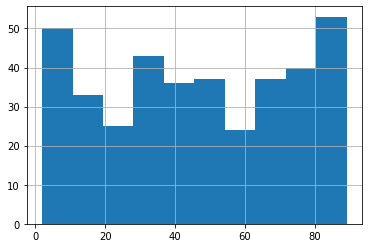

In [215]:
place_field_res['avg']['all_fields'][0,0]['com'].hist()

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/switch_analysis/shuffle_detection_switch_res_switch_magnitude_only_fr_mean.p.p exists; loading---


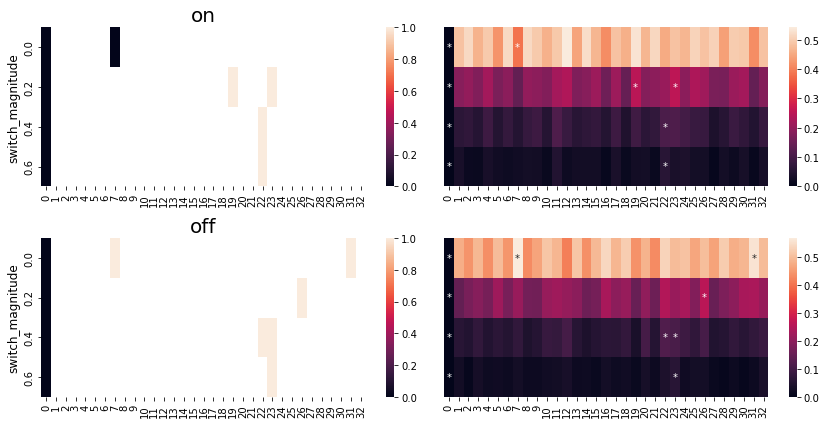

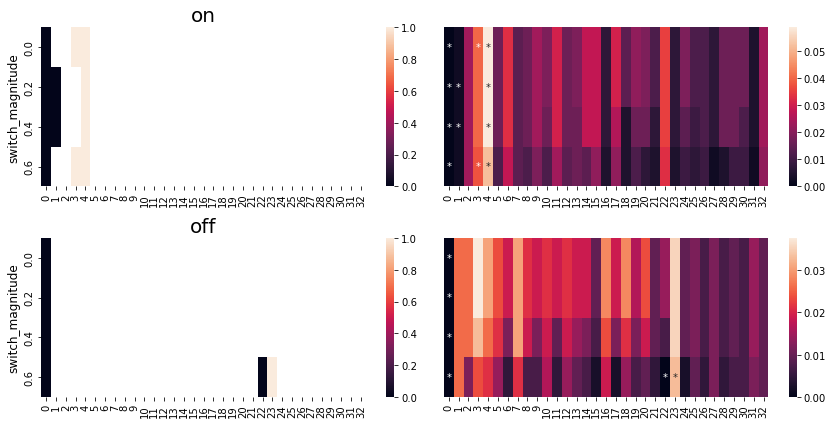

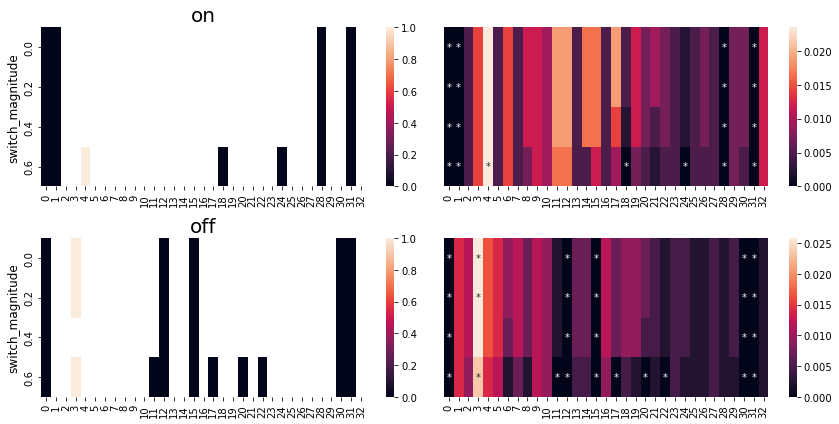

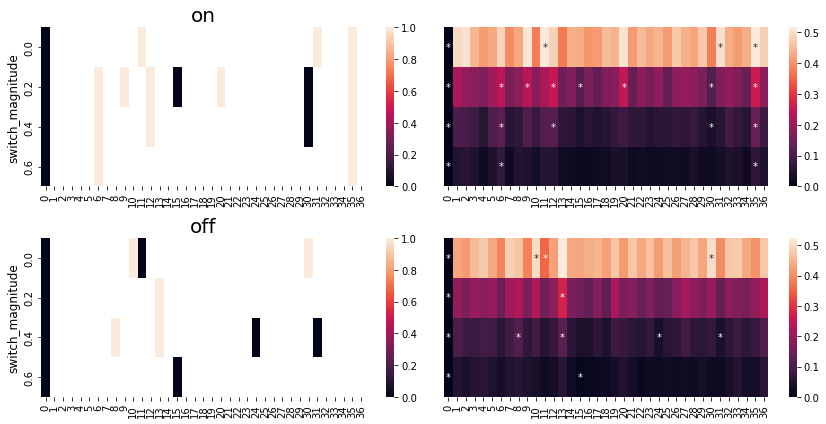

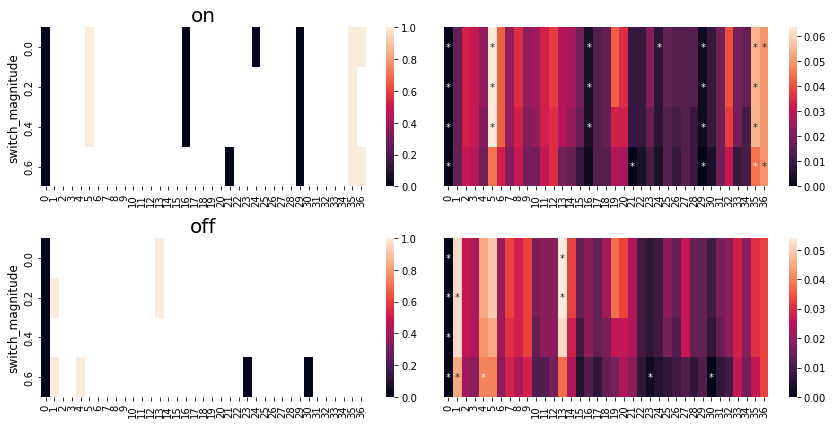

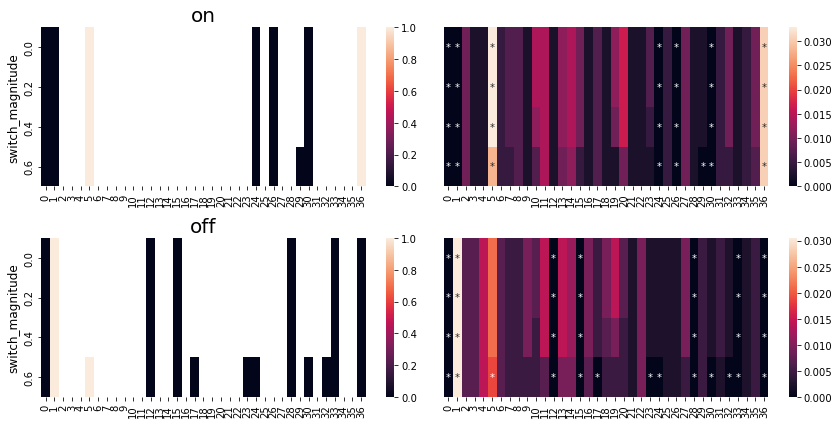

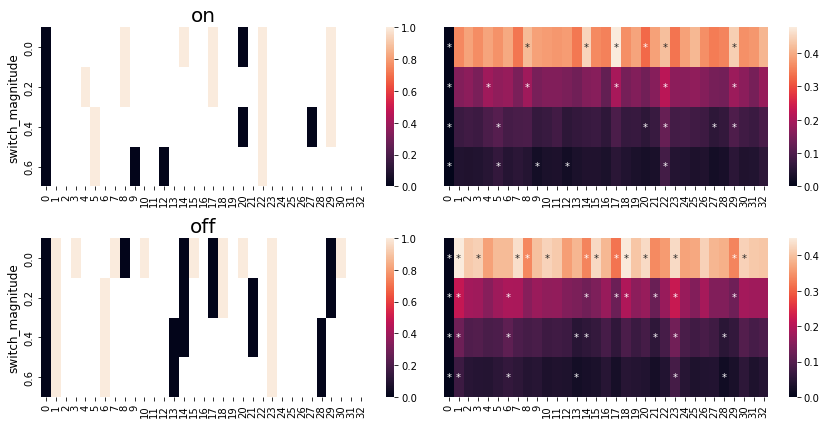

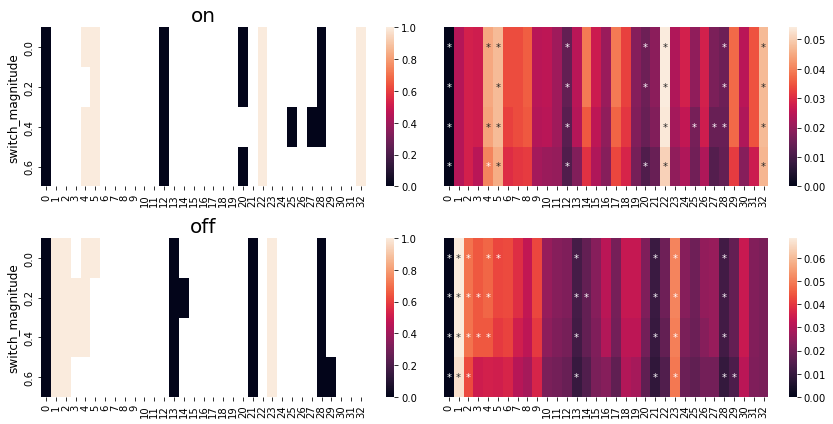

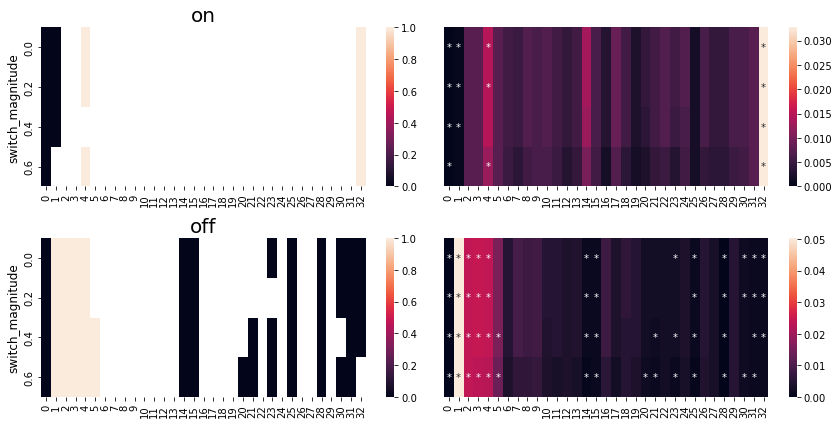

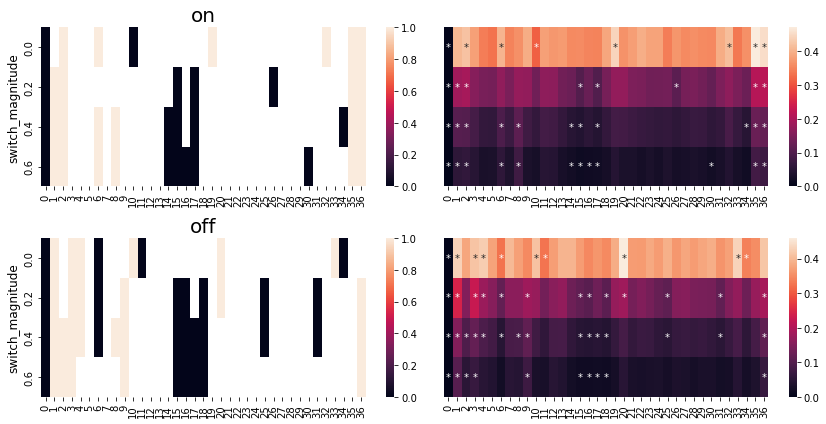

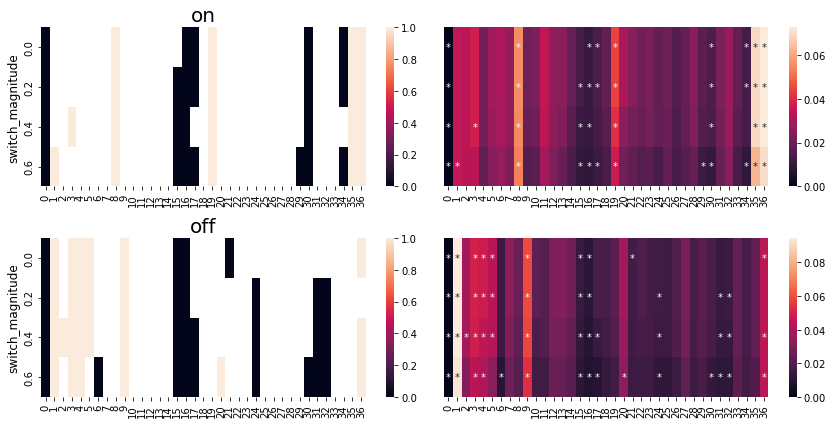

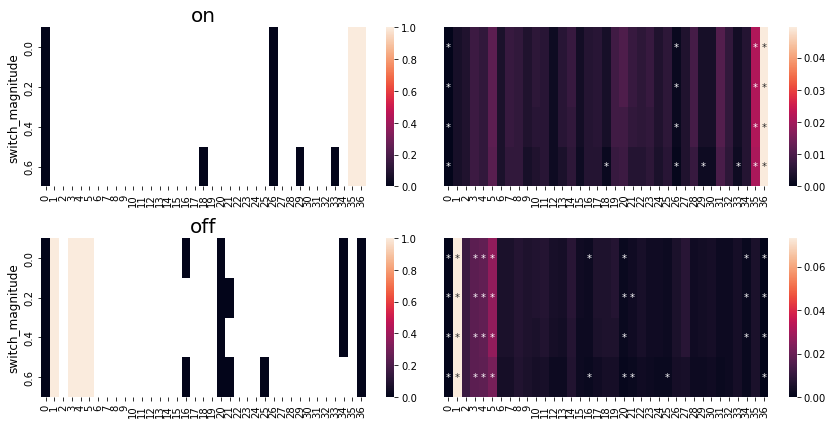

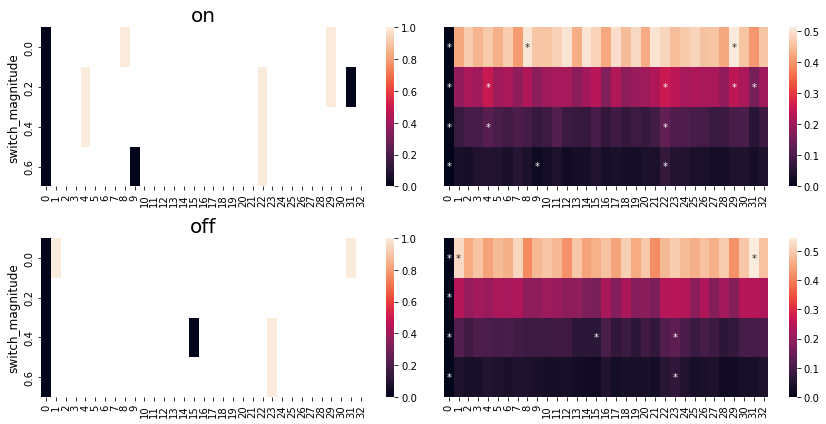

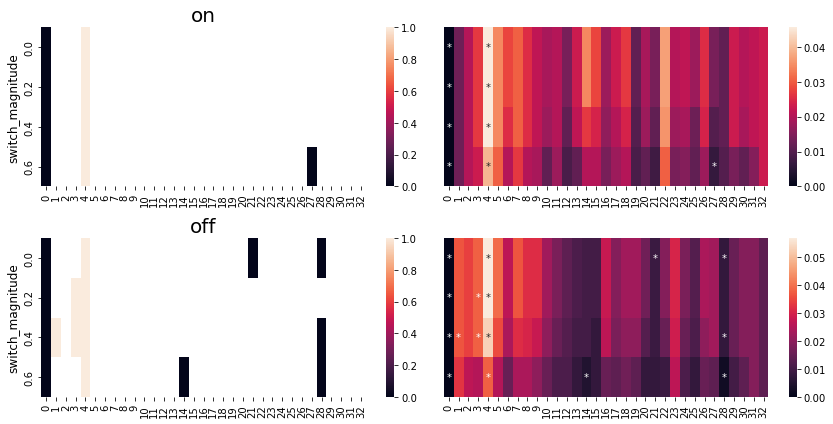

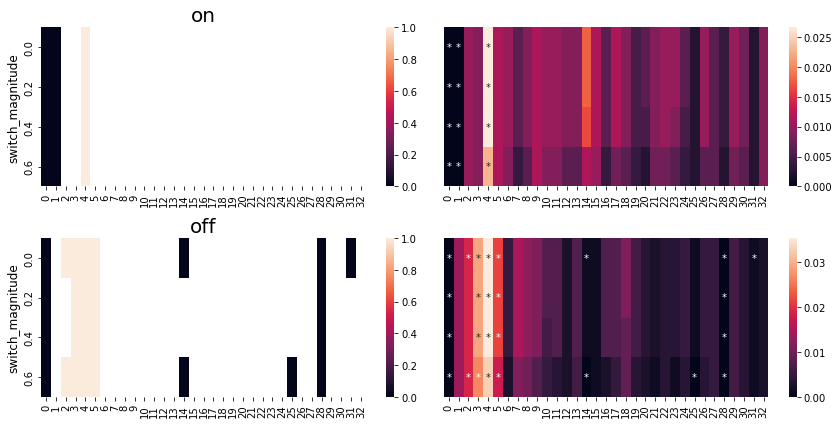

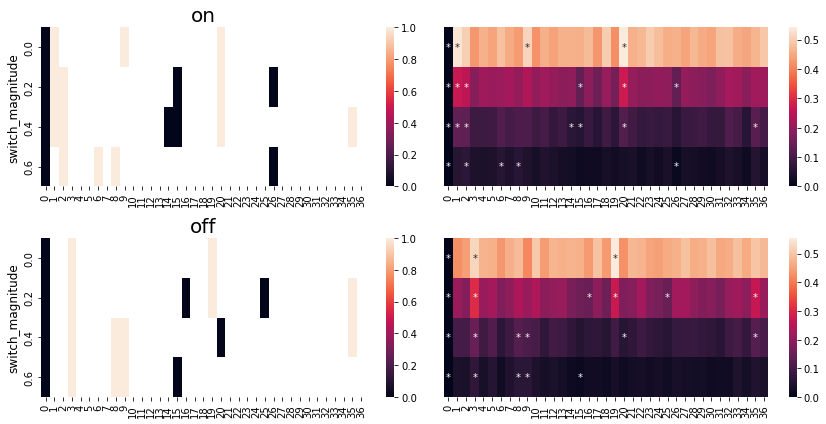

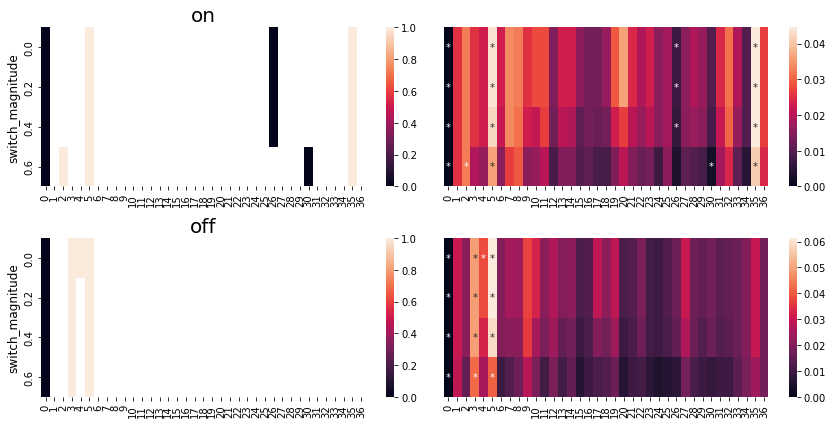

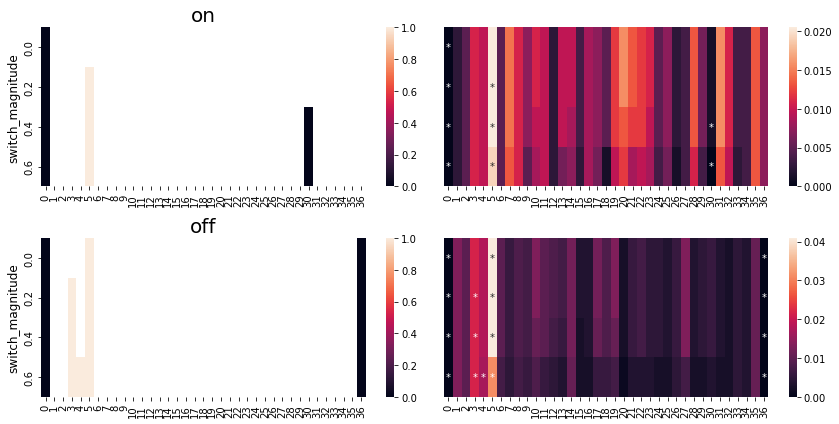

In [13]:
import misc
res_to_save_dir = os.path.join(data_dir_full,'py_data','switch_analysis')
res_to_save_name = f'shuffle_detection_switch_res_switch_magnitude_only_fr_mean.p.p'
res_to_save_fn  = os.path.join(res_to_save_dir,res_to_save_name+'.p')
res_to_save_data = misc.get_res(res_to_save_dir,res_to_save_name,False)[1]

In [216]:
X_all = {}
X_all_norm = {}
com_agg_all = {}
fr_key = 'fr_mean'
trial_type_l = [(0,0),(0,1)]

detection_type_l =[d for d in place_field_res.keys() if 'kwargs' not in d]

X_all_detection = {k:{} for k in detection_type_l}
X_all_norm_detection = {k:{} for k in detection_type_l}
com_agg_all_detection = {k:{} for k in detection_type_l}

for detection in detection_type_l:
    X_all = {}
    X_all_norm = {}
    com_agg_all = {}
    for tt in trial_type_l:
        X = place_field_res[detection]['params'][tt].loc[fr_key]
        com_agg = place_field_res[detection]['all_fields'][tt].loc[:,'com']
        X_all_detection[detection][tt] = X
        X_norm = X/X.max(axis=1).values[:,None]
        X_all_norm_detection[detection][tt] = X_norm
        com_agg_all_detection[detection][tt] = com_agg
    
    
    

In [54]:

reload(cpa)

<module 'change_point_analysis' from '/mnt/home/szheng/projects/nmf_analysis/change_point_analysis.py'>

In [217]:
X_to_be_analyzed_detection = {}
for k,val in X_all_norm_detection.items():
#     X_to_be_analyzed=cpa.turn_X_into_pwc_sweep(val,pen_l=[0.1,0.3,0.5])
    X_to_be_analyzed=cpa.turn_X_into_pwc_sweep(val,pen_l=[0.3,0.5])
    X_to_be_analyzed_detection[k] = X_to_be_analyzed

INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.

CPU times: user 2min 5s, sys: 3.87 s, total: 2min 9s
Wall time: 2min


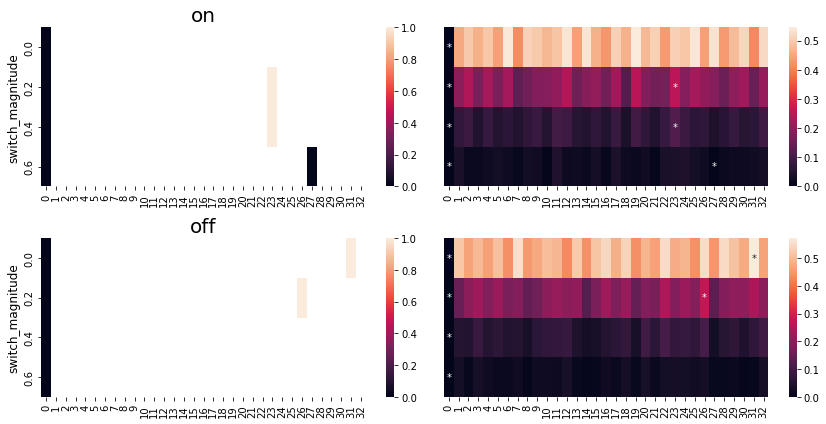

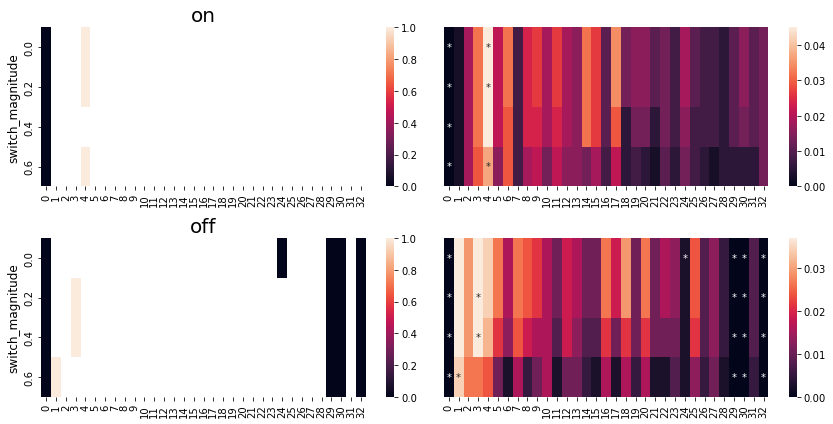

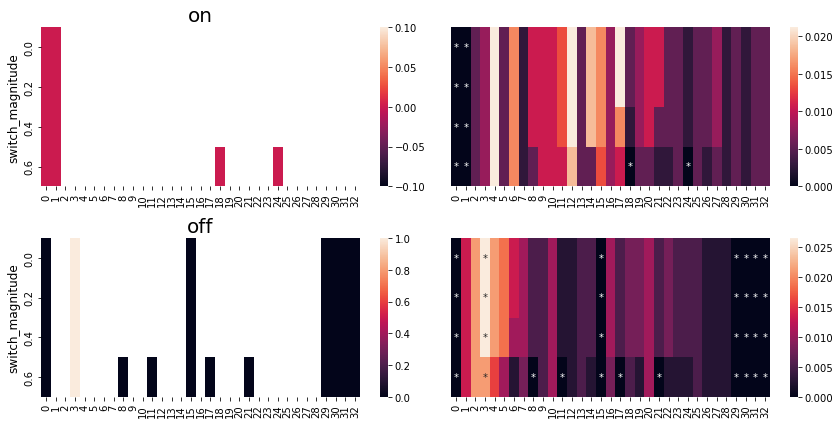

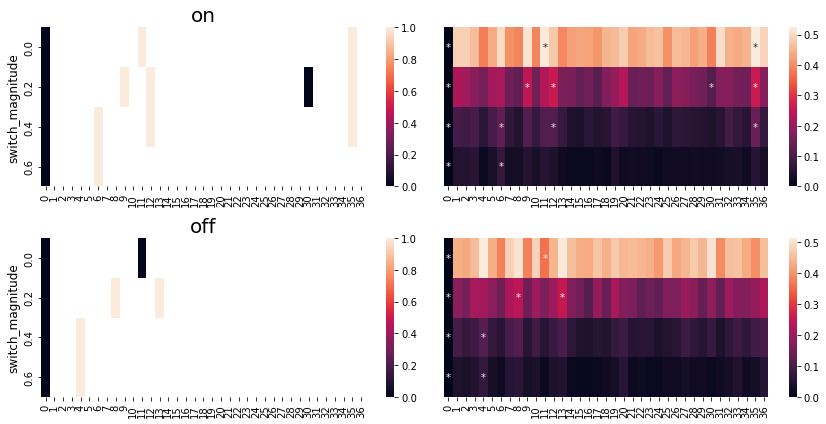

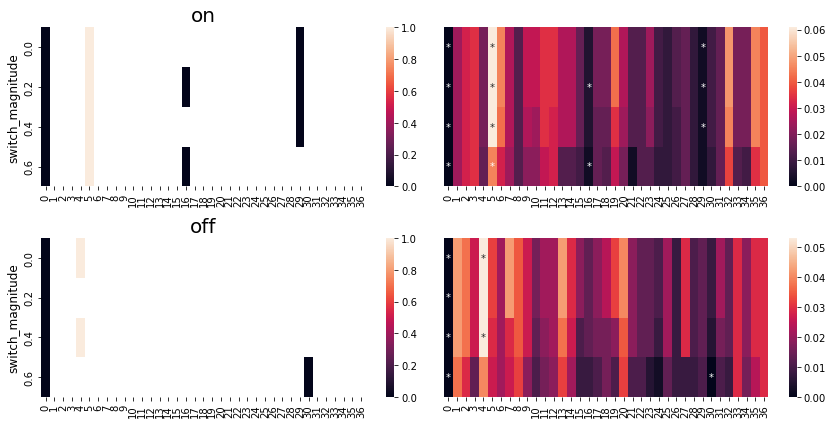

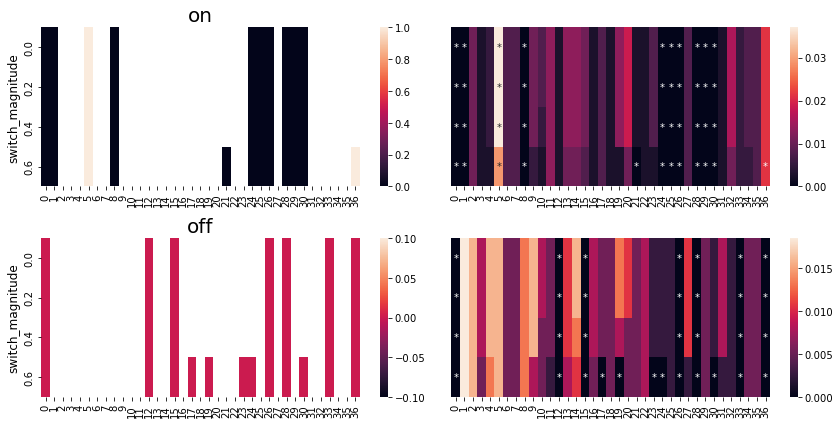

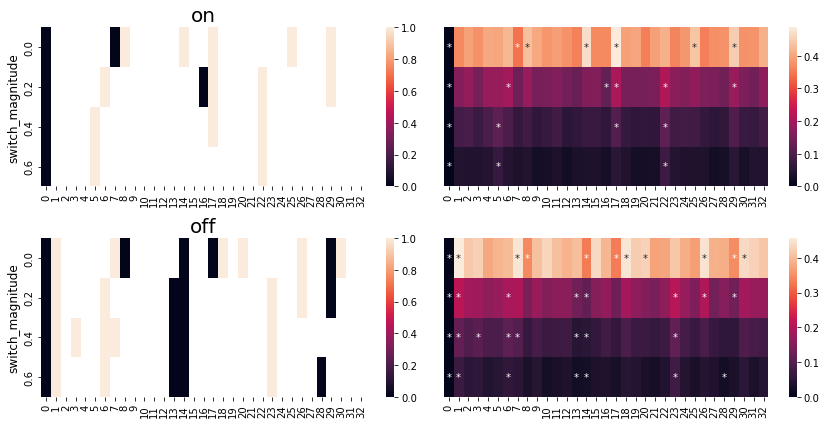

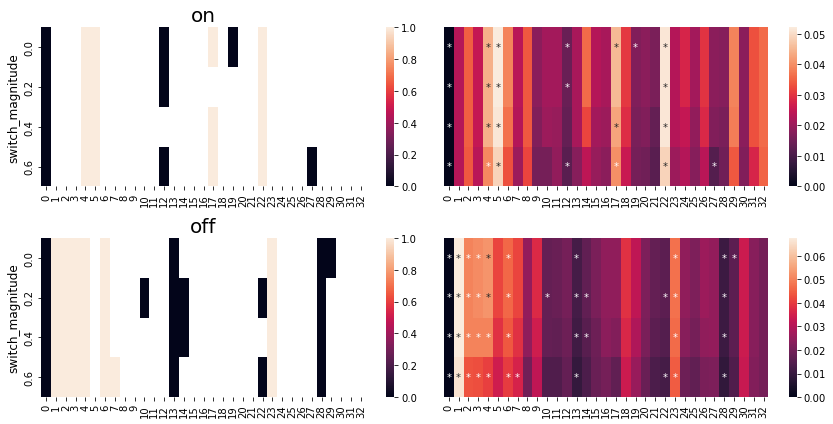

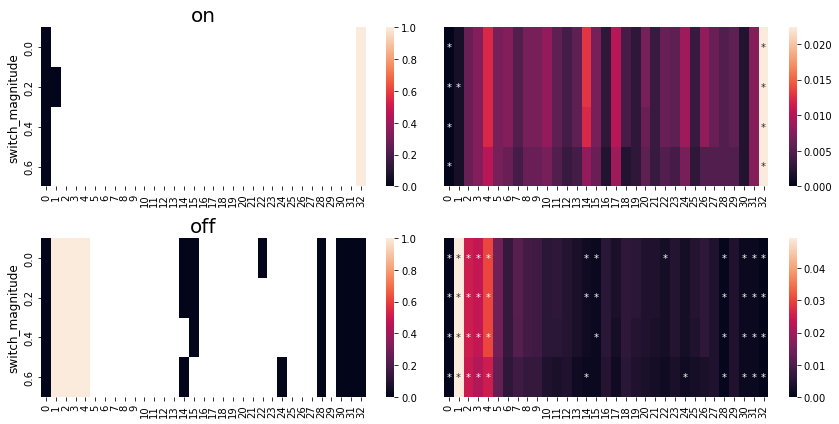

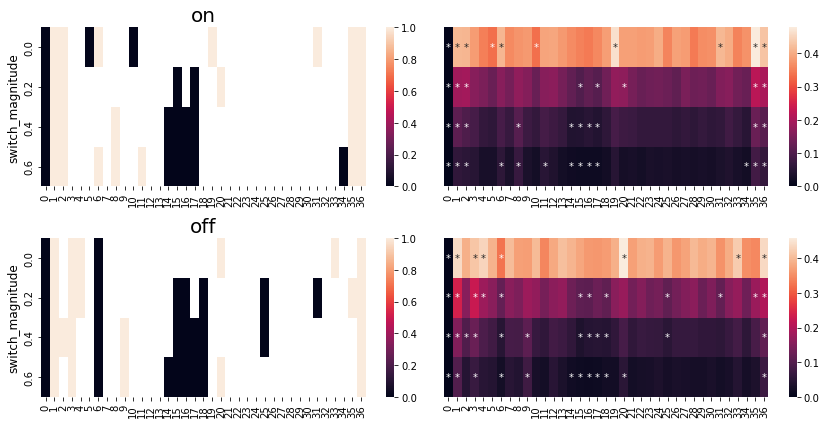

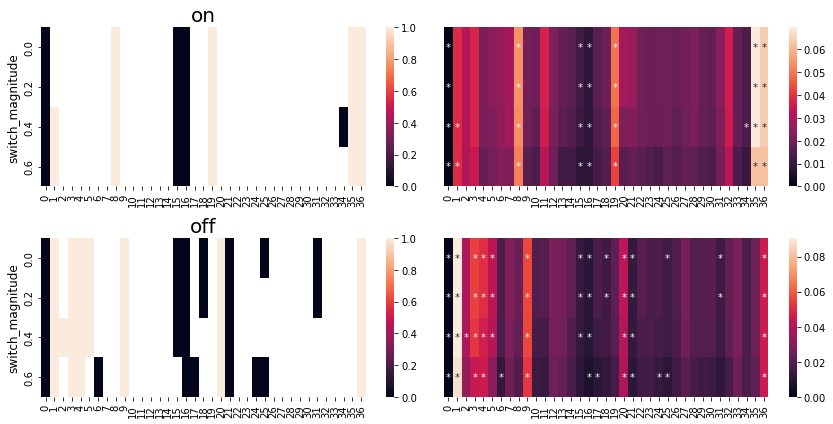

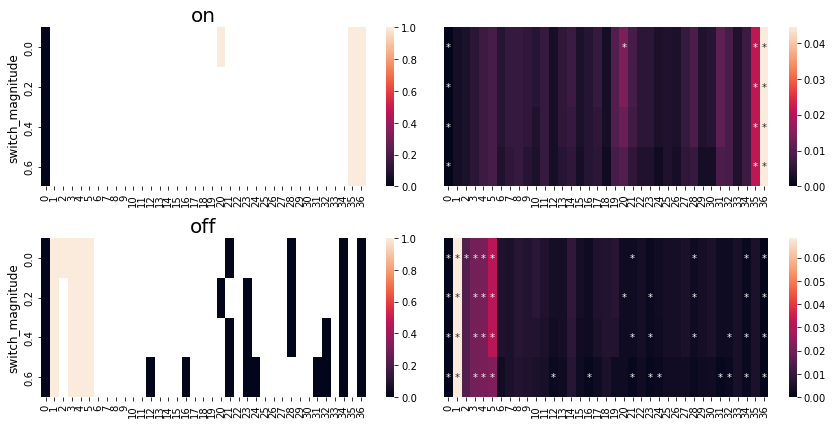

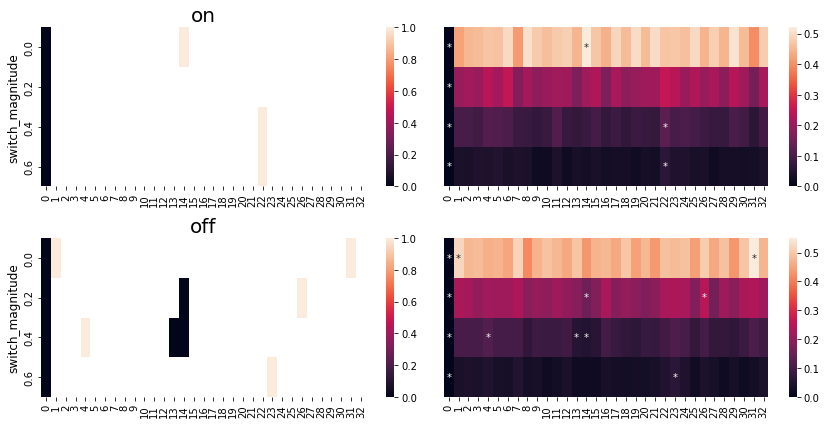

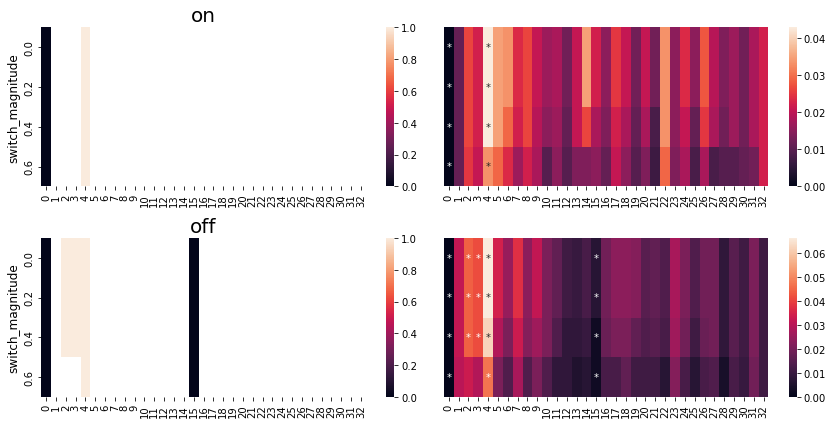

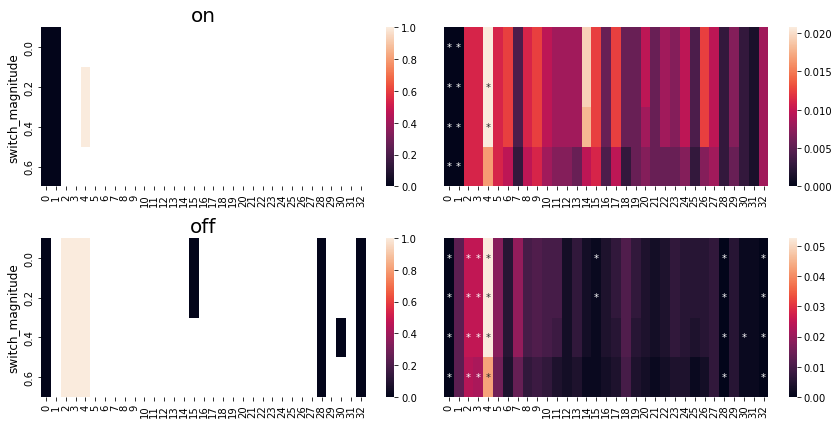

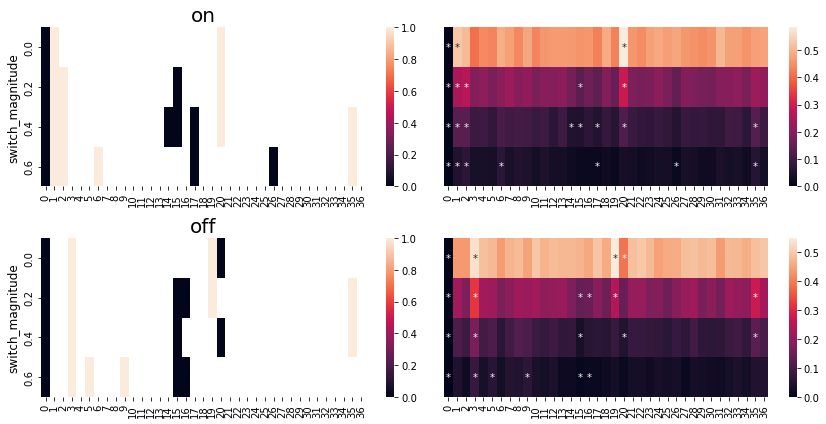

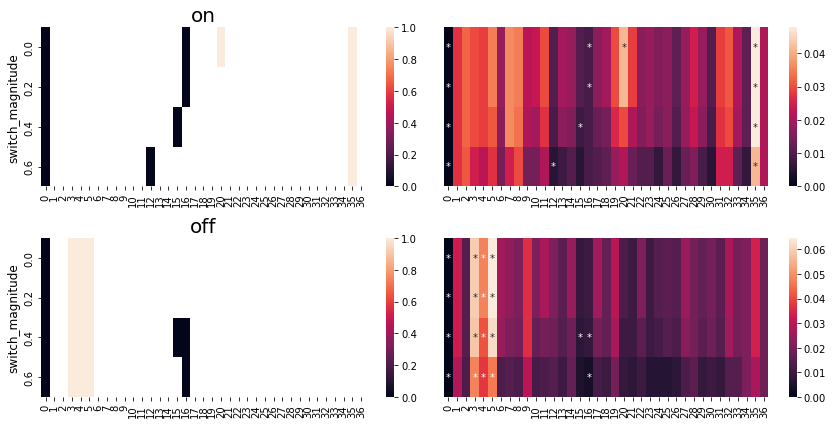

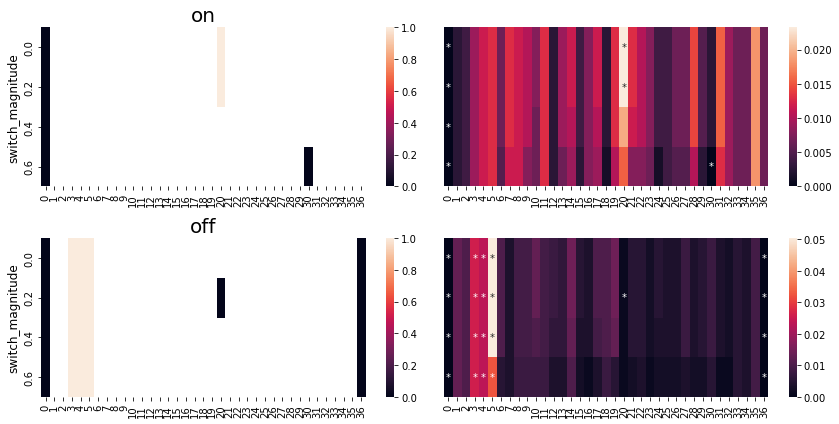

In [218]:
%%time
plt.ioff()
# tosweep_key_l = ['switch_magnitude','high_thresh']
# tosweep_val_l = [np.arange(0,0.7,0.1).round(1),np.arange(0.3,0.8,0.1).round(1)]
# kwargs_l = [dict(low_thresh=1,high_thresh=0),
#     dict(low_thresh=0.2,switch_magnitude = 0),
# ]
tosweep_key_l = ['switch_magnitude']
tosweep_val_l = [np.arange(0,0.7,0.2).round(1)]
kwargs_l = [dict(low_thresh=1,high_thresh=0)
]
min_size = 1

res_to_save_data_detection = {}
for detection,X_to_be_analyzed in X_to_be_analyzed_detection.items():
    cdf_alltrialtype,sig_alltrialtype,sr_alltrialtype,changes_df_alltrialtype,fig_alltrialtype = cpa.sweep_test_switch_ratio_multisweep_alltrialtype_multipreprocess(X_to_be_analyzed,min_size,tosweep_key_l,tosweep_val_l,kwargs_l,detect_func=cpa.detect_switch_pwc,alpha=0.05,do_bonf=True,doplots=True,nrepeats=1000)    

    res_to_save_data = dict(
        X = X_to_be_analyzed,
        cdf=cdf_alltrialtype,
        sig=sig_alltrialtype,
        sr=sr_alltrialtype,
        changes_df=changes_df_alltrialtype,
        fig=fig_alltrialtype
    )
    
    res_to_save_data_detection[detection] = res_to_save_data
    
    

In [219]:
res_to_save_dir = os.path.join(data_dir_full,'py_data','switch_analysis')
if not os.path.exists(res_to_save_dir):
    os.makedirs(res_to_save_dir)
    print(f'{res_to_save_dir} made!',flush=True)

res_to_save_name = f'shuffle_detection_vthresh_switch_res_switch_magnitude_only_{fr_key}'
res_to_save_fn  = os.path.join(res_to_save_dir,res_to_save_name+'.p')
res_to_save_data = res_to_save_data_detection
pickle.dump(res_to_save_data,open(res_to_save_fn,'wb'))
print(f'{res_to_save_fn} saved!', flush=True)

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean.p saved!


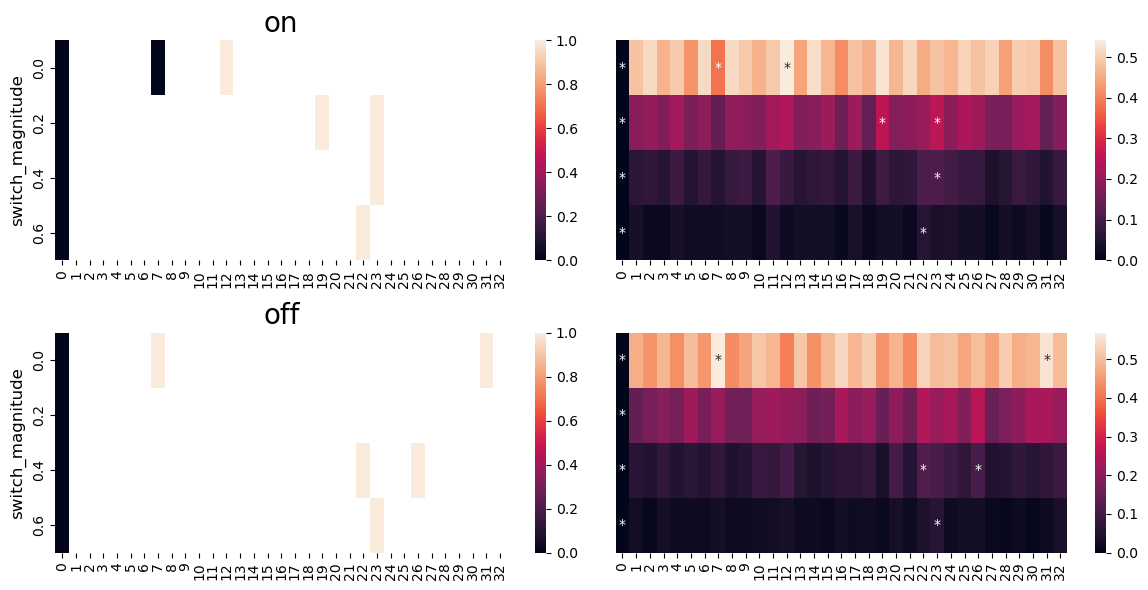

In [33]:
res_to_save_data_detection['avg']['fig'][0,0]['raw']['switch_magnitude']

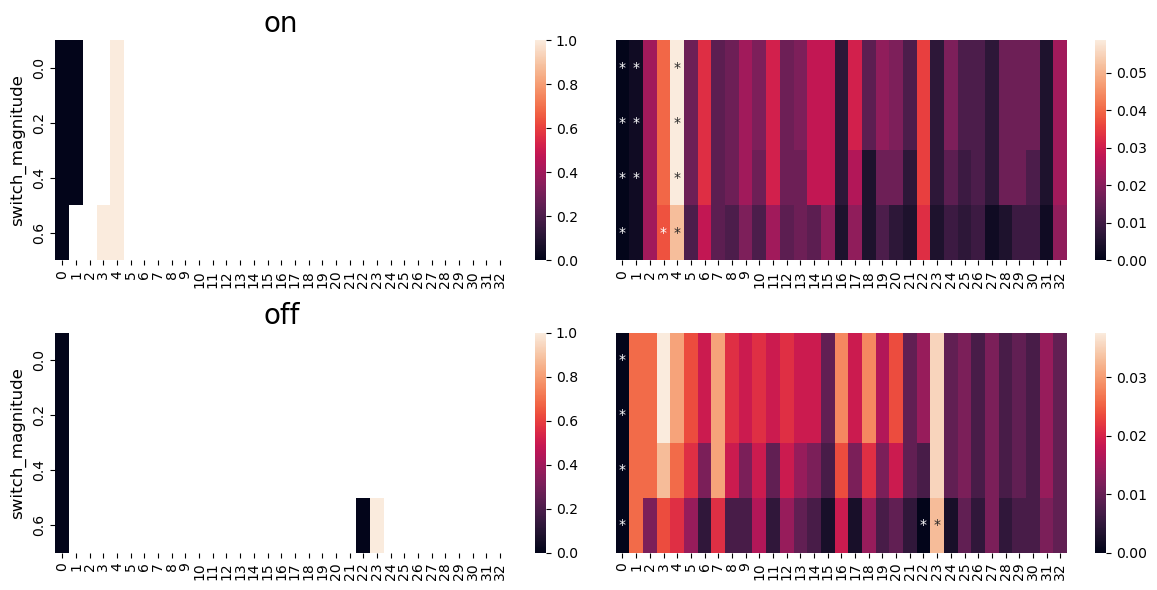

In [34]:
res_to_save_data_detection['avg']['fig'][0,0][0.3]['switch_magnitude']

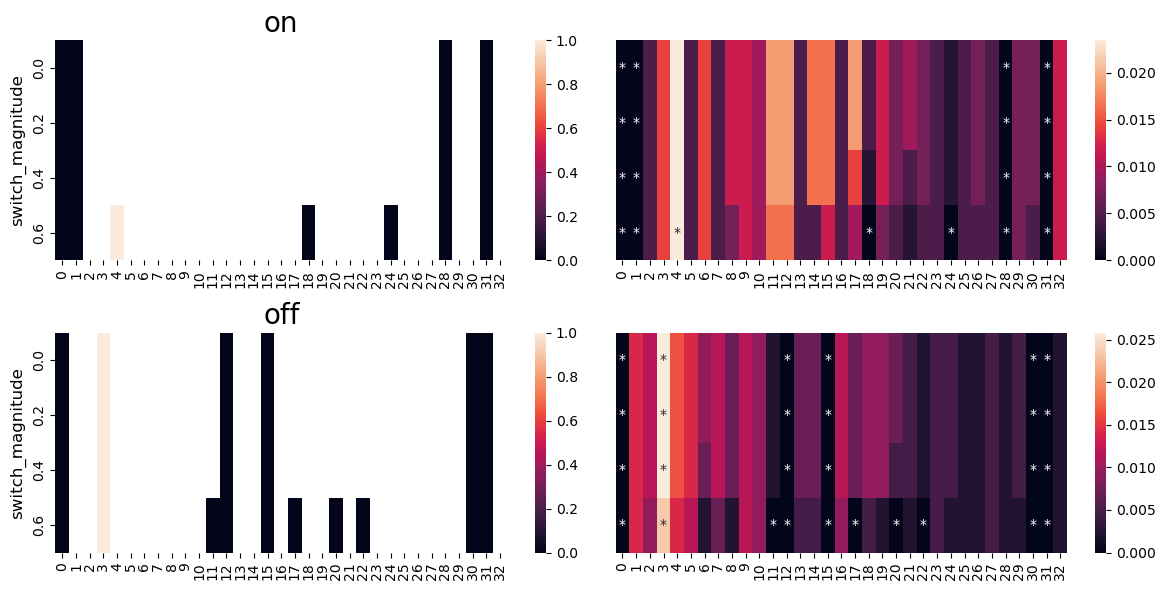

In [35]:
res_to_save_data_detection['avg']['fig'][0,0][0.5]['switch_magnitude']

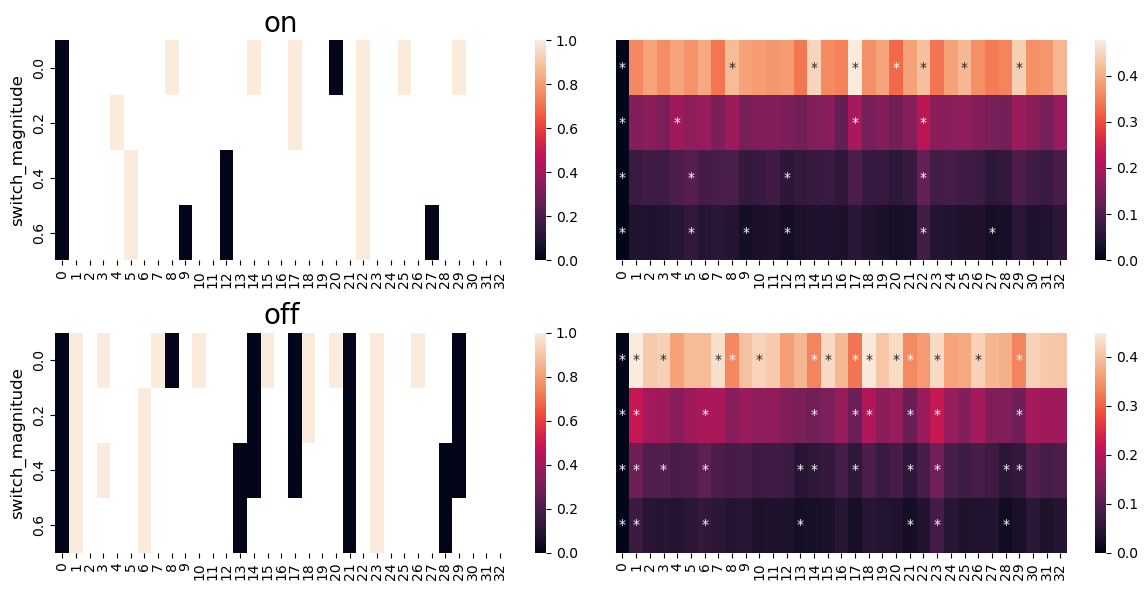

In [36]:
res_to_save_data_detection['trial']['fig'][0,0]['raw']['switch_magnitude']

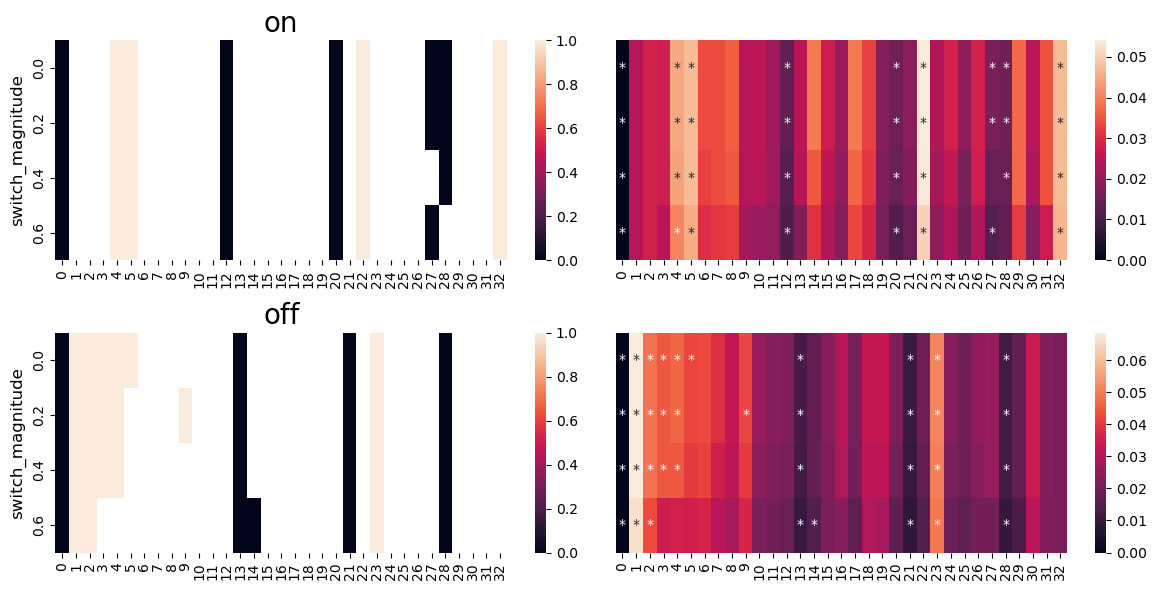

In [38]:
res_to_save_data_detection['trial']['fig'][0,0][0.3]['switch_magnitude']

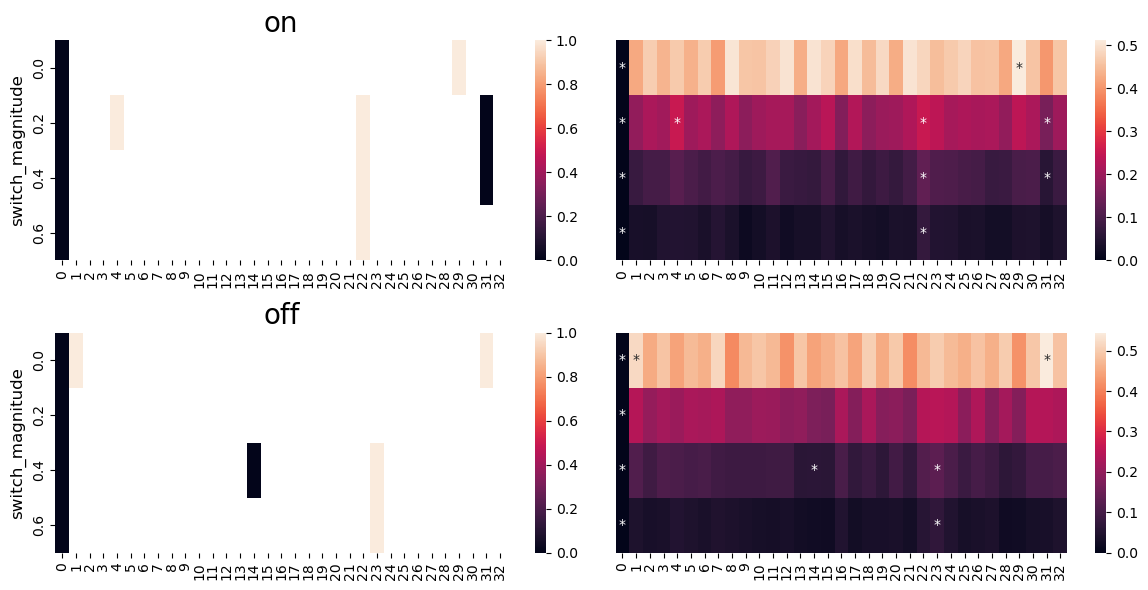

In [41]:
res_to_save_data_detection['trial_filter']['fig'][0,0]['raw']['switch_magnitude']

In [18]:
X_to_be_analyzed_detection = {detection:res_to_save_data[detection]['X'] for detection in res_to_save_data.keys()}

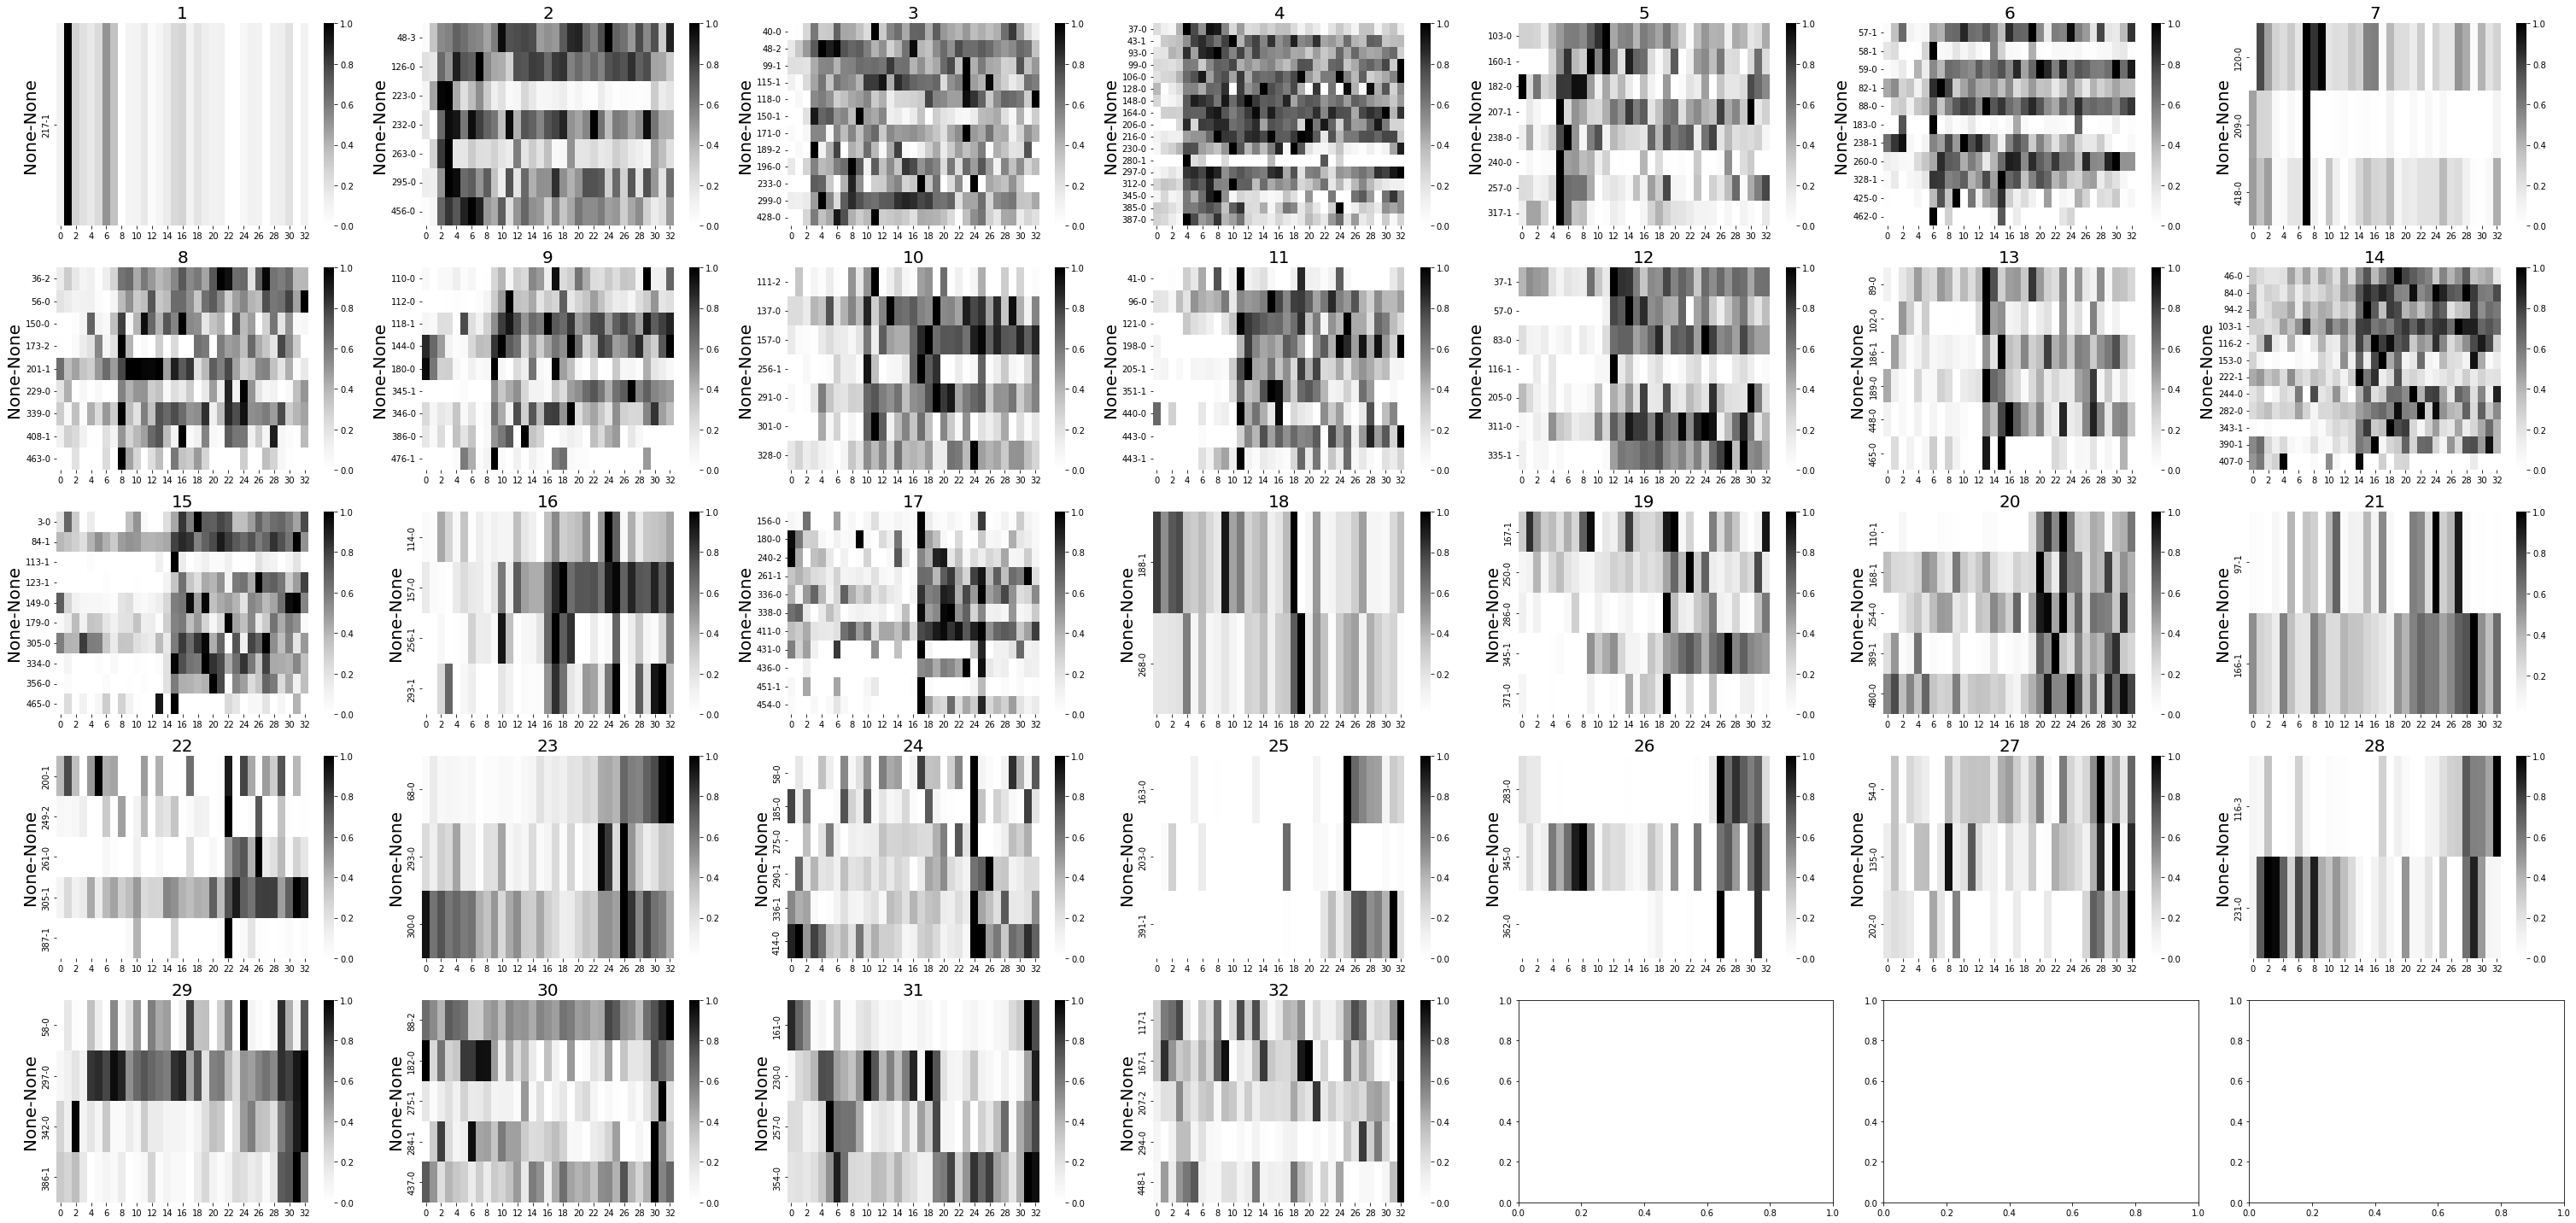

In [221]:
detection='avg'
trialtype = (0,0)
pen = 0.3
tosweep_key = 'switch_magnitude'
tosweep_val = 0.4
changes=res_to_save_data[detection]['changes_df'].loc[(*trialtype,pen,tosweep_key,tosweep_val),:]
inds_d = cpa.get_inds_switch_sametrial_sorted(changes)
fig,axs=cpp.plot_fields_switching_each_trial(X_to_be_analyzed_detection[detection]['raw'][trialtype],inds_d.loc[1])
# fig

<AxesSubplot:>

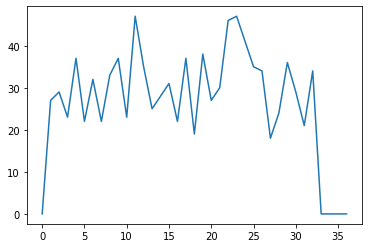

In [49]:
%matplotlib inline
(changes==1).sum(axis=0).plot()

In [307]:
import trial_correlates as tc
reload(tc)
speed_stats = tc.get_variable_statistics_per_trial(spk_beh_df,key='v')
time_related=tc.get_time_related_per_trial(spk_beh_df,speed_key='v')
firing_related=tc.get_firing_related_per_trial(spk_beh_df,cell_cols_d,speed_key='v',speed_thresh=1)
reward_related=tc.get_reward_related_per_trial(spk_beh_df)
try:
    ripples=mat_to_return['ripples']
    ripples_related=tc.get_ripples_related_per_trial(ripples,beh_df)
    has_ripples=True
except:
    has_ripples = False
    pass



In [316]:
ripples_related

ripple_count  ripple_rate
0 0.0 1.0              0     0.000000
      3.0              0     0.000000
      6.0              0     0.000000
      8.0              0     0.000000
      10.0             0     0.000000
...                  ...          ...
  1.0 62.0             2     0.132450
      64.0             2     0.212014
      66.0             1     0.169492
      67.0             1     0.517241
      69.0             0     0.000000

[70 rows x 2 columns]

In [278]:
changes_df_pivoted=(res_to_save_data[detection]['changes_df']).stack(dropna=True).unstack(level=(2,3,4))
switch_on_pivoted = changes_df_pivoted==1
switch_on_all=switch_on_pivoted.groupby(level=(0,1,4)).sum()

In [317]:
switch_on_all['v_mean'] = speed_stats['v_mean'].values
switch_on_all['v_cv'] = speed_stats['v_cv'].values
switch_on_all['idle_ratio']=time_related['idle_ratio'].values
switch_on_all['mean_fr_pyr'] = firing_related['mean_fr_pyr'].values
switch_on_all['frac_active_pyr'] = firing_related['frac_active_pyr'].values
switch_on_all['correct'] = reward_related['correct'].values
switch_on_all['correct_prev'] = reward_related['correct_prev'].values
switch_on_all['ripple_count'] = ripples_related['ripple_count'].values
switch_on_all['ripple_rate'] = ripples_related['ripple_rate'].values



In [324]:
df=switch_on_all.rcorr()

In [328]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [329]:
df

raw                                      0.3                                      0.5                          v_mean    v_cv idle_dur idle_ratio mean_fr_pyr frac_active_pyr correct correct_prev ripple_count ripple_rate
                                     switch_magnitude                         switch_magnitude                         switch_magnitude                                                                                                                                      
                                                  0.0     0.2     0.4     0.6              0.0     0.2     0.4     0.6              0.0     0.2     0.4     0.6                                                                                                              
raw             switch_magnitude 0.0                -     ***     ***      **               **      **      **      **               **      **       *       *                                                                                                              
                                 0.2            0.839       -     ***     ***              ***     ***     ***     ***               **      **      **     ***                                                                       *                                      
                                 0.4            0.595    0.82       -     ***              ***     ***     ***     ***               **      **      **      **                                                                     ***                         *            
                                 0.6            0.376   0.525   0.818       -              ***     ***     ***     ***                                                                                                               **                                      
0.3             switch_magnitude 0.0             0.35   0.477   0.609   0.561                -     ***     ***     ***              ***     ***     ***     ***                                                                       *                         *           *
                                 0.2             0.35   0.477   0.609   0.561              1.0       -     ***     ***              ***     ***     ***     ***                                                                       *                         *           *
                                 0.4            0.331   0.469   0.602   0.547            0.989   0.989       -     ***              ***     ***     ***     ***                                                                       *                         *           *
                                 0.6            0.308   0.455    0.61    0.59            0.933   0.933   0.941       -              ***     ***     ***     ***                                                                      **                        **          **
0.5             switch_magnitude 0.0             0.31   0.374   0.309    0.13            0.718   0.718   0.712    0.59                -     ***     ***     ***                                                                                                              
                                 0.2             0.31   0.374   0.309    0.13            0.718   0.718   0.712    0.59              1.0       -     ***     ***                                                                                                              
                                 0.4            0.304   0.384    0.32   0.134            0.724   0.724    0.73   0.609             0.99    0.99       -     ***                                                                                                              
                                 0.6            0.282   0.386   0.333   0.137            0.671   0.671   0.701   0.649              0.9     0.9   0.919       -                                                                                                 *           *


In [337]:
ma[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=object)

In [349]:
annot

array([[0, '***', '***', '**', '**', '**', '**', '**', '**', '**', '*',
        '*', '', '', '', '', '', '', '', '', '', ''],
       [0, 0, '***', '***', '***', '***', '***', '***', '**', '**', '**',
        '***', '', '', '', '', '', '', '*', '', '', ''],
       [0, 0, 0, '***', '***', '***', '***', '***', '**', '**', '**',
        '**', '', '', '', '', '', '', '***', '', '*', ''],
       [0, 0, 0, 0, '***', '***', '***', '***', '', '', '', '', '', '',
        '', '', '', '', '**', '', '', ''],
       [0, 0, 0, 0, 0, '***', '***', '***', '***', '***', '***', '***',
        '', '', '', '', '', '', '*', '', '*', '*'],
       [0, 0, 0, 0, 0, 0, '***', '***', '***', '***', '***', '***', '',
        '', '', '', '', '', '*', '', '*', '*'],
       [0, 0, 0, 0, 0, 0, 0, '***', '***', '***', '***', '***', '', '',
        '', '', '', '', '*', '', '*', '*'],
       [0, 0, 0, 0, 0, 0, 0, 0, '***', '***', '***', '***', '', '', '',
        '', '', '', '**', '', '**', '**'],
       [0, 0, 0, 0, 0, 0

<AxesSubplot:>

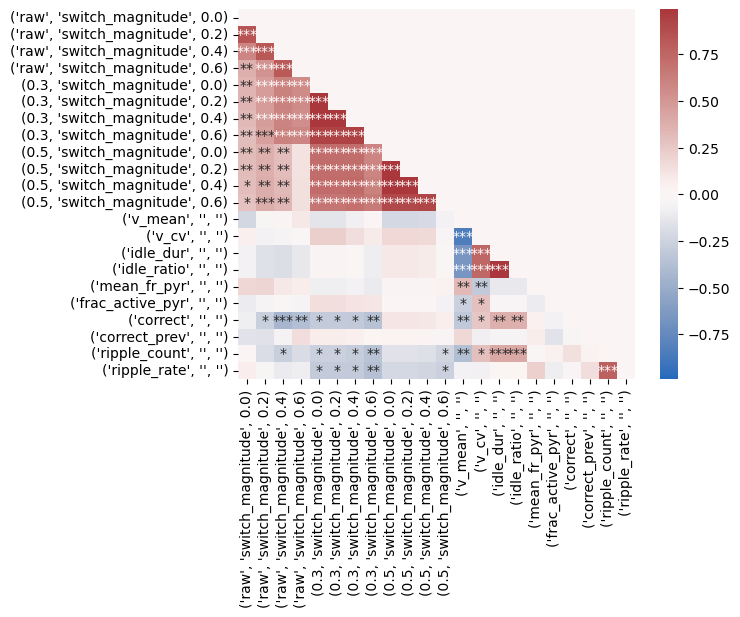

In [357]:
reload(ph)
ma= np.tril(df.values,-1)
annot=np.triu(df.values,1).T
annot[annot==0]=''
ph.diverging_heatmap(ma.astype(float),annot=annot,fmt='',xticklabels=df.columns,yticklabels=df.index)

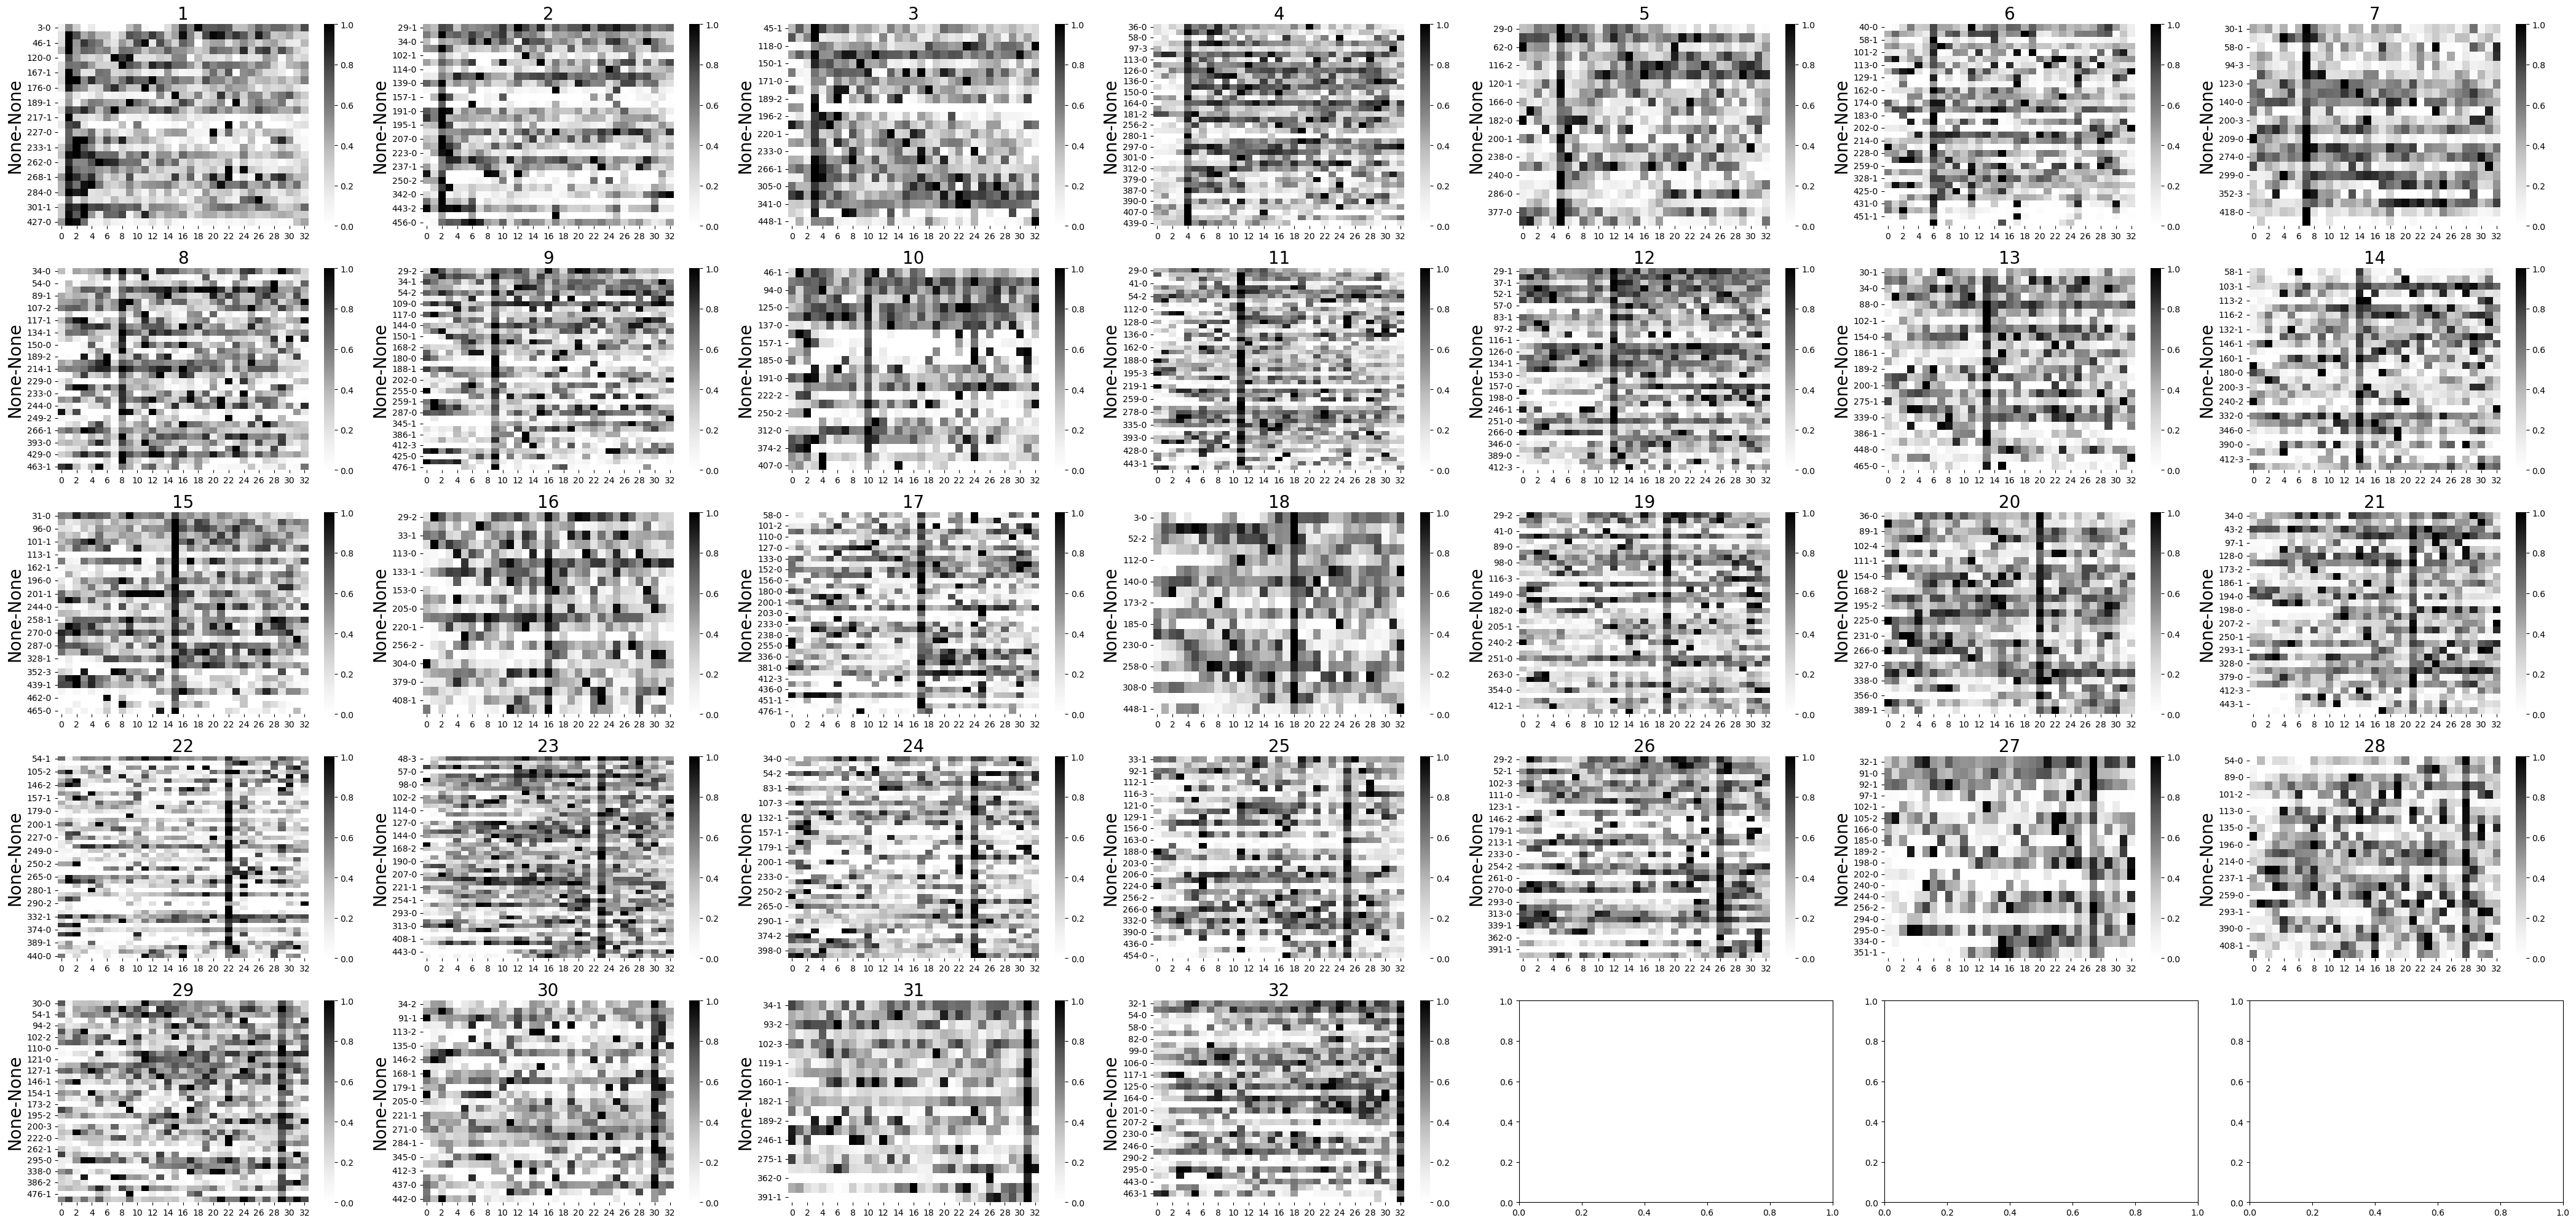

In [45]:
fig

In [ ]:
kde = scipy.stats.gaussian_kde
kernel = scipy.stats.gaussian_kde(location_to_be_clustered,bw_method=self.bw_method)
pdf = kernel(self.allposbins)

In [20]:
all_fields=place_field_res[detection]['all_fields'][trialtype]
all_fields

start end com peak    fr_peak    fr_mean
    field_index                                         
3   0              24  40  32   32   2.198769   1.191852
27  0               0  29  14   15  27.412618  21.826155
29  0               1  10   5    6    5.97748   5.471898
    1              20  38  29   29  22.086391   13.66571
    2              69  84  76   77  12.952853   9.355671
...               ...  ..  ..  ...        ...        ...
475 0              23  42  33   36   4.553163   2.876875
476 0              27  40  33   29   1.140031   0.931988
    1              42  49  45   45   1.083715   0.846759
479 2              95  99  97   99   1.177758   0.936548
480 0              71  90  80   81   8.686505   6.324198

[426 rows x 6 columns]

In [70]:
reload(cpa)
coswitching_coms,coswitching_coms_binned,field_loc_histogram = cpa.get_swtiching_com_distribution_per_trial(all_fields,inds_d, field_loc_key='com',coarse_bins=np.arange(0,101,10))



In [44]:
reload(pa)
fr_map_trial_using_v=pa.get_fr_map_trial(spk_beh_df,cell_cols,trialtype_key='trial_type',gauss_width=2.5,order=['smooth','divide'],n_lin_bins=100,speed_key='v')




cant format into a dataframe
cant format into a dataframe


In [48]:
fr_map_trial_using_v[0,0][0].shape

(422, 100, 33)

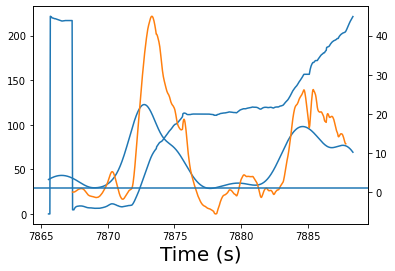

In [41]:
ax=spk_beh_df.loc[spk_beh_df['trial']==0]['lin'].plot()
ax2 = ax.twinx()
ax2=spk_beh_df.loc[spk_beh_df['trial']==0]['speed'].plot(ax=ax2)
ax2=spk_beh_df.loc[spk_beh_df['trial']==0]['v'].plot(ax=ax2)
ax2.axhline(1)
# ax.set_ylim([0,20])

In [72]:
coswitching_coms_binned

0  1  2  3  4  5  6  7  8   9
 1 1   2  0  0  5  5  3  3  3  4   2
   2   4  0  4  5  4  0  0  3  6   3
   3   2  0  3  4  2  2  5  1  1   3
   4   8  8  7  3  1  2  1  3  3   1
   5   2  5  0  3  1  3  2  1  2   3
...   .. .. .. .. .. .. .. .. ..  ..
-1 28  7  3  1  2  0  0  2  5  4   0
   29  4  6  1  2  2  0  4  0  3  10
   30  3  2  1  7  2  2  1  1  1   6
   31  3  9  1  2  1  5  1  2  5   3
   32  3  2  0  0  5  3  6  0  9   9

[64 rows x 10 columns]

In [88]:
p

,-1,1
0,0.077047,0.082974
1,0.080492,0.082386
2,0.059267,0.064655
3,0.068396,0.063090
4,0.059840,0.067819
5,0.067383,0.070312
6,0.070312,0.074777
7,0.049107,0.052296
8,0.075781,0.077344
9,0.093750,0.087171


In [93]:
p * (1-p)

,-1,1
0,0.071111,0.076089
1,0.074013,0.075599
2,0.055755,0.060475
3,0.063718,0.059109
4,0.056260,0.063220
5,0.062842,0.065369
6,0.065369,0.069185
7,0.046696,0.049561
8,0.070038,0.071362
9,0.084961,0.079572


In [96]:
base

array([1856, 1056,  928, 1696, 1504, 1024,  896, 1568, 1280, 1824])

<AxesSubplot:>

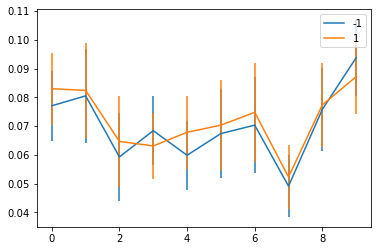

In [98]:
switching_count = coswitching_coms_binned.groupby(level=0).sum()
ntrials = coswitching_coms_binned.loc[1].shape[0]
base = field_loc_histogram * ntrials
p = (switching_count / base).T
se = np.sqrt((p * (1-p)) / base[:,None])
p.plot(yerr=se * 1.96)


In [75]:
from statsmodels.stats.proportion import proportions_ztest

In [79]:
base

array([1856, 1056,  928, 1696, 1504, 1024,  896, 1568, 1280, 1824])

In [99]:
proportions_ztest(switching_count.loc[1,[6,7]],base[[6,7]])

(2.2521215011703397, 0.024314594901675014)

In [ ]:
scipy.stats.binom_test()

In [51]:
inds_d.loc[1]

1   0       (3, 0)
    1      (29, 2)
    2      (46, 1)
    3     (107, 3)
    4     (120, 0)
            ...   
32  29    (352, 3)
    30    (443, 0)
    31    (448, 1)
    32    (463, 1)
    33    (479, 2)
Length: 989, dtype: object